<a href="https://colab.research.google.com/github/chenwh0/ARC-AGI-hackathon/blob/main/train_AGI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installs & Imports**

In [ ]:
import os, json, re, gc
from pprint import pprint
import numpy as np
from scipy.ndimage import label
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from collections import deque
import math
import pandas

# Cosine similarity libraries
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
ENCODER = SentenceTransformer('all-MiniLM-L6-v2')


In [ ]:
ARC_AGI2_PATH = "/content/drive/MyDrive/AGI_hackathon/ARC_AGI2/"
ARC_AGI2_TRAIN_PATH = ARC_AGI2_PATH + "arc-agi_training_challenges.json"
ARC_AGI2_TRAIN_LABELS_PATH = ARC_AGI2_PATH + "arc-agi_training_solutions.json"
ARC_AGI2_EVAL_PATH = ARC_AGI2_PATH + "arc-agi_evaluation_challenges.json"
ARC_AGI2_EVAL_LABELS_PATH = ARC_AGI2_PATH + "arc-agi_evaluation_solutions.json"
ARC_AGI2_TEST_PATH = ARC_AGI2_PATH + "arc-agi_test_challenges.json"


LLM_NAME = "tiiuae/falcon-7b-instruct"
PARTIAL_EVERY = 100
MAX_NEW_TOKENS = 256
TEMPERATURE = 0.2
TOP_P = 0.9

EMBEDDINGS_FILE_PATH = "/content/drive/MyDrive/AGI_hackathon/embedded_numpy_context.pkl"

RESULTS_DIR = "results_json"
FIGURES_DIR = "figures"

# **Utility functions setup**
Load data

In [ ]:
def load_json(file_path):
    isExistingFile = os.path.isfile(file_path)
    if not isExistingFile:
        print(f"\n❌ File at '{file_path}' does not exist")
    with open(file_path, "r") as file:
        data = json.load(file)
    print(f"💾 Loaded {len(data)} items from {file_path}")
    return data

def create_dir(path):
    """Create dir in path. Don't raise error if dir exists already"""
    os.makedirs(path, exist_ok=True)

def convert_2D_numpy(arr):
    """Ensure arr is 2D int numpy array, force non-numeric to 0."""
    numpy_array = np.array(arr)

    if numpy_array.ndim != 2:
        raise ValueError("convert_2D_numpy: Input is not 2D")

    # Convert to numeric, replacing non-numeric with 0
    try:
        return numpy_array.astype(int)
    except:
        return np.array([[int(x) if str(x).isdigit() else 0 for x in row] for row in numpy_array], dtype=int)


def calculate_accuracy(predict_arr: np.array, true_arr: np.array):
    return np.mean(predict_arr == true_arr)

def pad_to_shape(predict_arr: np.array, true_arr: np.array):
    """Pad arr with 0 to at least match true shape for visualization"""
    start = true_arr.shape
    target = np.zeros(start)

    end_row = min(start[0] + predict_arr.shape[0], target.shape[0])
    end_col = min(start[1] + predict_arr.shape[1], target.shape[1])
    rows = end_row - start[0]
    cols = end_col - start[1]
    target[start[0]:end_row, start[1]:end_col] = predict_arr[:rows, :cols]
    return

def visualize_diff(input_arr: np.array, predict_arr: np.array, true_arr: np.array, task_id, agent_name):
    different_size = False
    if predict_arr is None or true_arr is None:
        print("\n❌ predict_arr or true_arr is None")
        return 0.0, np.ones_like(true_arr)
    if predict_arr.shape != true_arr.shape:
        different_size = True
        predict_arr = np.zeros(true_arr.shape)

    accuracy = np.mean(predict_arr == true_arr)
    print(f"\n{agent_name} | ✅ Accuracy: {accuracy:.3f} | Task ID = {task_id}")
    diff_mask = (predict_arr != true_arr)

    # Visualize
    custom_colors = ["white", "#ff0000","#ff8700","#ffe97f","#83e377","#0aff99","#90caf9","#147df5","#a713f6","#f9b4ed"]
    custom_cmap = mcolors.ListedColormap(custom_colors)
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))

    axes[0].imshow(input_arr, cmap=custom_cmap, vmin=0, vmax=9); axes[0].set_title("Input") # "tab20"
    axes[1].imshow(predict_arr, cmap=custom_cmap, vmin=0, vmax=9); axes[1].set_title("Predicted")
    axes[2].imshow(true_arr, cmap=custom_cmap, vmin=0, vmax=9); axes[2].set_title("True")
    axes[3].imshow(diff_mask, cmap="coolwarm", vmin=0, vmax=1); axes[3].set_title("Diff Mask")
    for ax in axes:
        ax.axis("off")
        ax.set_xticks([])
    plt.suptitle(f"{agent_name} | Accuracy: {accuracy:.2f} | Task ID = {task_id}", fontsize=11)
    fig_path = os.path.join(FIGURES_DIR, f"{task_id}_{agent_name}.png")
    plt.savefig(fig_path, dpi=150)
    plt.show()
    plt.close(fig)

    return accuracy, diff_mask

In [ ]:
def create_example_summary(accuracy, all_learned_operations, best_arr, input_arr, true_arr):
    # Extract only the descriptions for the summary
    learned_operation_descriptions = [
        desc for ops_per_example in all_learned_operations
        for op_group in ops_per_example
        for agent_name, operations in op_group.items()
        for _, desc in operations  # unpack (func, description)
    ]

    example_summary = {
        "accuracy": accuracy,
        "learned_operations": learned_operation_descriptions,
        "best_predict_arr": best_arr,
        "input_arr": input_arr,
        "true_arr": true_arr,
        "diff_mask": (best_arr != true_arr)
    }
    # Create example's prompt
    example_summary["prompt"] = f"""Agents can't solve task. Best accuracy={example_summary["accuracy"]:.2f} using operations {example_summary["learned_operations"]}.
    best_predict_arr={example_summary["best_predict_arr"]}
    input_arr={example_summary["input_arr"]}
    true_arr={example_summary["true_arr"]}
    differences={example_summary["diff_mask"]}"""

    return example_summary

def create_final_prompt(examples_summaries):
    if len(examples_summaries) > 1:
        best_accuracy = max(examples_summaries, key=lambda x: x["accuracy"])
        second_best_accuracy = max((ex for ex in examples_summaries if ex is not best_accuracy), key=lambda x: x["accuracy"])
        examples_prompt = f"""Example1: {best_accuracy["prompt"]}\nExample2: {second_best_accuracy["prompt"]}""" # Include top 2 accuracy examples in prompt if there's many examples
    else:
        examples_prompt = f"""Example1: {examples_summaries[0]["prompt"]}"""

    chain_of_reasoning_prompt = """\n1. Identify what is still different
2. List the reasoning behind input_arr -> true_arr?
3. Generalize reasoning so it'll work for other similar examples
4. Generate python code that would solve this task
"""
    final_prompt = examples_prompt + chain_of_reasoning_prompt
    return final_prompt

In [ ]:
train_data = load_json(ARC_AGI2_TRAIN_PATH)
train_label = load_json(ARC_AGI2_TRAIN_LABELS_PATH)
eval_data = load_json(ARC_AGI2_EVAL_PATH)
eval_label = load_json(ARC_AGI2_EVAL_LABELS_PATH)
test_data = load_json(ARC_AGI2_TEST_PATH)

train_ids = list(train_data.keys())
eval_ids = list(eval_data.keys())
test_ids = list(test_data.keys())

💾 Loaded 1000 items from /content/drive/MyDrive/AGI_hackathon/ARC_AGI2/arc-agi_training_challenges.json
💾 Loaded 1000 items from /content/drive/MyDrive/AGI_hackathon/ARC_AGI2/arc-agi_training_solutions.json
💾 Loaded 120 items from /content/drive/MyDrive/AGI_hackathon/ARC_AGI2/arc-agi_evaluation_challenges.json
💾 Loaded 120 items from /content/drive/MyDrive/AGI_hackathon/ARC_AGI2/arc-agi_evaluation_solutions.json
💾 Loaded 240 items from /content/drive/MyDrive/AGI_hackathon/ARC_AGI2/arc-agi_test_challenges.json


In [ ]:
create_dir(FIGURES_DIR)
create_dir(RESULTS_DIR)

# **LLM setup**
Falcon-7B (H100 Optimized)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(LLM_NAME)
LLM = AutoModelForCausalLM.from_pretrained(
    LLM_NAME,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    low_cpu_mem_usage=True
)
generator = pipeline(
    "text-generation",
    model=LLM,
    tokenizer=tokenizer,
    max_new_tokens=MAX_NEW_TOKENS,
    temperature=TEMPERATURE,
    do_sample=False,
    return_full_text=False
)

def call_falcon_llm(prompt: str):
    formatted_prompt = f"### Instruction:\n{prompt}\n\n### Response:\n"
    outputs = generator(
        formatted_prompt,
        return_full_text=False
    )
    return outputs[0]["generated_text"].strip()

## RAG component

In [ ]:
NUMPY_FUNCTIONS_DOCUMENTATION = [
    {   "functionName": "np.allclose",
        "description": "Compare grids allowing symbolic equivalence."},
    {   "functionName": "np.equal.outer",
        "description": "Compare color relationships across positions."},
    {   "functionName": "np.sum",
        "description": "Count filled cells per row or column."},
    {   "functionName": "np.any",
        "description": "Detect presence of a color in rows or columns."},
    {   "functionName": "np.all",
        "description": "Detect full rows or columns."},
    {   "functionName": "np.maximum",
        "description": "Overlay objects by dominance (non-zero overwrite)."},
    {   "functionName": "np.minimum",
        "description": "Overlay objects with masking semantics."},
    {   "functionName": "np.take",
        "description": "Extract values along an axis using explicit indices."},
    {   "functionName": "np.put",
        "description": "Write values into flattened grid locations."},
    {   "functionName": "np.equal",
        "description": "Create masks for a specific color."},
    {   "functionName": "np.not_equal",
        "description": "Create masks excluding a color."},
    {   "functionName": "np.logical_and",
        "description": "Combine multiple spatial conditions."},
    {   "functionName": "np.logical_or",
        "description": "Union of spatial conditions."},
    {   "functionName": "np.logical_not",
        "description": "Invert a mask."},
    {   "functionName": "np.where",
        "description": "Conditionally replace values in a grid or return coordinates where a condition holds."},
    {   "functionName": "np.argwhere",
        "description": "Return explicit (row, col) coordinates of matching cells."},
    {   "functionName": "np.nonzero",
        "description": "Get indices of nonzero (non-background) cells."},
    {   "functionName": "np.zeros",
        "description": "Create an empty background grid."},
    {   "functionName": "np.full",
        "description": "Create a grid filled with a single color."}
]

def get_context_embeddings():
    for function_info in NUMPY_FUNCTIONS_DOCUMENTATION:
        embedded_context = ENCODER.encode([function_info["description"]])
        function_info["embedding"] = embedded_context
    dataframe = pandas.DataFrame(NUMPY_FUNCTIONS_DOCUMENTATION)
    dataframe.to_pickle(EMBEDDINGS_FILE_PATH)  # pickle to preserve vectors
    return dataframe

def RAG_numpy_functions(response):
    # Embed LLM response
    response_embedding = ENCODER.encode(response).reshape(1, -1)
    similarities = []

    for _, row in NUMPY_CONTEXT_EMBEDDINGS.iterrows():
        function_embedding = row["embedding"].reshape(1, -1)
        score = cosine_similarity(response_embedding, function_embedding)[0][0]

        similarities.append({
            "functionName": row["functionName"],
            "description": row["description"],
            "score": float(score)
        })

    similarities.sort(key=lambda x: x["score"], reverse=True) # Sort by similarity score (descending)
    return similarities[:3] # Get top 3 functions

In [ ]:
NUMPY_CONTEXT_EMBEDDINGS = get_context_embeddings()

# **Operations setup**
Load Resize, Transforms, Recolor, Erase, FillGaps, etc.

## Completed

In [ ]:
class ResizeAgent:
    def __init__(self):
        self.learned_operations = []
        self.target_shape = None

    def retile(self, input_arr: np.ndarray):
        """Return arr with target_shape (use arr as repeated tiling if extra squares needed)"""
        if input_arr.ndim != 2: # Not 2D array
            return np.zeros(self.target_shape, dtype=int)

        input_rows, input_columns = input_arr.shape
        true_rows, true_columns = self.target_shape
        if input_rows == 0 or input_columns == 0:
            return np.zeros(self.target_shape, dtype=int)
        repeat_row_factor = max(1, int(np.ceil(true_rows/input_rows)))
        repeat_column_factor = max(1, int(np.ceil(true_columns/input_columns)))

        retiled = np.tile(input_arr, (repeat_row_factor, repeat_column_factor))
        return retiled[:true_rows, :true_columns]
    def grow(self, input_arr: np.ndarray):
        input_rows, input_columns = input_arr.shape
        true_rows, true_columns = self.target_shape
        if input_rows == 0 or input_columns == 0:
            return np.zeros(self.target_shape, dtype=int)
        repeat_row_factor = int(np.ceil(true_rows/input_rows))
        repeat_column_factor = int(np.ceil(true_columns/input_columns))
        expanded = np.kron(input_arr, np.ones((repeat_row_factor, repeat_column_factor), dtype=int))
        return expanded[:true_rows,:true_columns]

    def retile_and_grow(self, input_arr: np.ndarray):
        retiled = self.retile(input_arr)
        input_diff_mask = self.grow(input_arr)
        input_diff_mask = input_diff_mask[:retiled.shape[0], :retiled.shape[1]]
        if input_diff_mask.size == 0:
            input_diff_mask = np.ones_like(retiled)
        masked_retiled = np.copy(retiled)
        masked_retiled[input_diff_mask == 0] = 0
        return masked_retiled


    def operations(self):
        return {
            "retileToShape": self.retile,
            "growToShape": self.grow,
            "retileAndGrow": self.retile_and_grow
        }

    def try_all_operations(self, input_arr: np.array, predict_arr: np.array, true_arr: np.array, id: str, accuracy: float):
        if input_arr.shape != true_arr.shape: # Resize if input & true has different shape
            self.target_shape = true_arr.shape
        else:  # Return input_arr as predict_arr for other Agents to process
            accuracy, diff_mask = visualize_diff(input_arr, input_arr, true_arr, id, f"No resizing, using input")
            return input_arr, accuracy
        best_predict = None
        best_accuracy = accuracy
        for name, func in self.operations().items():
            guess = func(input_arr)  # retile or grow
            new_accuracy, diff_mask = visualize_diff(input_arr, guess, true_arr, id, f"ResizeAgent - {name}")
            if new_accuracy > best_accuracy:
                best_accuracy = new_accuracy
                best_predict = np.copy(guess)
                self.learned_operations = []
                self.learned_operations.append((func, f"{name}"))
                if new_accuracy >= 1.0:
                    best_predict = np.copy(guess)
                    best_accuracy = new_accuracy
                    break

        # If no resize improved accuracy, fallback to first guess
        if best_predict is None:
            best_predict = self.retile(input_arr)
            best_accuracy = np.mean(best_predict == true_arr)

        return best_predict, best_accuracy

In [ ]:
class TransformsAgent: # Simple transformations
    def __init__(self):
        self.learned_operations = []

    def horizontal_flip(self, input_arr: np.ndarray):
        return np.fliplr(input_arr)
    def vertical_flip(self, input_arr: np.ndarray):
        return np.flipud(input_arr)
    def rotate(self, input_arr: np.ndarray, rotate90_counts=1):
        return np.rot90(input_arr, rotate90_counts)
    def shift_up(self, input_arr: np.ndarray):
        return np.roll(input_arr, -1, axis=0)
    def shift_down(self, input_arr: np.ndarray):
        return np.roll(input_arr, 1, axis=0)
    def shift_left(self, input_arr: np.ndarray):
        return np.roll(input_arr, -1, axis=1)
    def shift_right(self, input_arr: np.ndarray):
        return np.roll(input_arr, 1, axis=1)
    def transpose(self, input_arr: np.ndarray):
        """Turn columns into rows and rows into columns"""
        return input_arr.T

    def operations(self):
        return {
            "horizontalFlip": self.horizontal_flip,
            "verticalFlip": self.vertical_flip,
            "rotate90": lambda x: self.rotate(x, 1),
            "rotate180": lambda x: self.rotate(x, 2),
            "rotate270": lambda x: self.rotate(x, 3),
            "shiftUp": self.shift_up,
            "shiftDown": self.shift_down,
            "shiftLeft": self.shift_left,
            "shiftRight": self.shift_right,
            "transpose": self.transpose
        }

    def apply_on_diff(self, predict_arr, diff_mask, func):
        if predict_arr.ndim < 2 or diff_mask.ndim < 2: # Can't transform individual squares
            return predict_arr
        tmp_arr = np.copy(predict_arr)

        diff_coordinates = np.argwhere(diff_mask == 1)
        min_row, min_column = diff_coordinates.min(axis=0)
        max_row, max_column = diff_coordinates.max(axis=0) + 1
        diff_2D = tmp_arr[min_row:max_row, min_column:max_column]
        mask_2D = diff_mask[min_row:max_row, min_column:max_column].astype(bool) # 1s and 0s

        transformed_area = func(diff_2D)
        if transformed_area.shape != diff_2D.shape:
            # Swap axes if rotated
            if transformed_area.shape[::-1] == diff_2D.shape:
                transformed_area = np.transpose(transformed_area)
            else:
                # Fallback: crop or pad
                transformed_area = transformed_area[:diff_2D.shape[0], :diff_2D.shape[1]]

        transformed_arr = np.copy(predict_arr)
        old_diff_area = transformed_arr[min_row:max_row, min_column:max_column]
        old_diff_area[mask_2D] = transformed_area[mask_2D] # Apply only on the incorrect squares within 2D mask
        transformed_arr[min_row:max_row, min_column:max_column] = old_diff_area
        return transformed_arr

    def try_all_operations(self, input_arr: np.array, predict_arr: np.array, true_arr: np.array, id: str, accuracy: float):
        diff_mask = (predict_arr != true_arr)
        for name, func in self.operations().items():
            guess = self.apply_on_diff(predict_arr, diff_mask, func)
            new_accuracy, diff_mask = visualize_diff(input_arr, guess, true_arr, id, f"TransformsAgent - {name}")
            if new_accuracy > accuracy:
                self.learned_operations = []
                self.learned_operations.append((func, f"{name}"))
                accuracy = new_accuracy
                if accuracy >= 1.0:
                    predict_arr = np.copy(guess)
                    break
        return predict_arr, accuracy

In [ ]:
class RecolorAgent:
    def __init__(self):
        self.learned_operations = []
        self.potential_colors = []
        self.is_input_color_important = True
        self.best_colors = []
    def learn_colors(self, input_arr: np.array, true_arr: np.array):
        input_colors = np.unique(input_arr)
        true_colors = np.unique(true_arr)
        common_colors = np.intersect1d(input_arr, true_arr)
        common_colors = common_colors[common_colors != 0] # Remove 0 (black) if it is common color
        if len(common_colors) == 0:
            self.potential_colors.extend(np.unique(true_arr).tolist())
            self.is_input_color_important = False # true colors aren't in input_arr
        else:
            self.potential_colors.extend(common_colors.tolist())
            self.is_input_color_important = True # Add colors that input_arr AND true_arr have

    def recolor_most_common_color(self, predict_arr: np.array, true_arr: np.array):
        flat = predict_arr.ravel()
        counts = np.bincount(flat)

        # get most common
        most_common_color = counts.argmax()

        if most_common_color == 0: # Ignore black
            counts_zeroed = counts.copy()
            counts_zeroed[0] = -1
            most_common_color = counts_zeroed.argmax()

        best_accuracy = calculate_accuracy(predict_arr, true_arr)
        best_arr = np.copy(predict_arr)
        for color in list(set(self.potential_colors)):
            guess = np.copy(predict_arr)
            guess[guess == most_common_color] = color  # Recolor the most_common_color squares
            accuracy = calculate_accuracy(guess, true_arr)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_arr = np.copy(guess)
                self.best_colors.append(color)
                if best_accuracy >= 1.0:
                    break
        return best_arr, best_accuracy

    def operations(self):
        return {
            "recolorMostCommonColor": lambda predict_arr, true_arr: self.recolor_most_common_color(predict_arr, true_arr)
        }

    def try_all_operations(self, input_arr: np.array, predict_arr: np.array, true_arr: np.array, id: str, accuracy: float):
        self.learn_colors(input_arr, true_arr)
        for name, func in self.operations().items():
            guess, new_accuracy = func(predict_arr, true_arr)
            new_accuracy, diff_mask = visualize_diff(input_arr, guess, true_arr, id, f"RecolorAgent - {name}, color(s) = {self.best_colors}")
            if new_accuracy > accuracy:
                self.learned_operations = []
                self.learned_operations.append((func, f"{name}, color(s) = {self.best_colors}"))
                accuracy = new_accuracy
                predict_arr = np.copy(guess)
                if accuracy >= 1.0:
                    break
        return predict_arr, accuracy




class EraseAgent:
    def __init__(self):
        self.learned_operations = []
    def erase_least_common_color(self, input_arr: np.array):
        flat = input_arr.ravel()
        nonzero = flat[flat != 0]

        if len(nonzero) == 0:
            return input_arr  # nothing to erase

        unique, counts = np.unique(nonzero, return_counts=True)
        least_common_color = unique[counts.argmin()]

        predict_arr = np.copy(input_arr)
        predict_arr[predict_arr == least_common_color] = 0

        return predict_arr


    def operations(self):
        return {
            "eraseLeastCommonColor": self.erase_least_common_color
        }
    def try_all_operations(self, input_arr: np.array, predict_arr: np.array, true_arr: np.array, id: str, accuracy: float):
        for name, func in self.operations().items():
            guess = func(predict_arr)
            new_accuracy, diff_mask = visualize_diff(input_arr, guess, true_arr, id, f"EraseAgent - {name}")
            if new_accuracy > accuracy:
                self.learned_operations = []
                self.learned_operations.append((func, f"{name}"))
                accuracy = new_accuracy
                predict_arr = np.copy(guess)
                if accuracy >= 1.0:
                    break
        return predict_arr, accuracy

In [ ]:
class FillGapsAgent:
    def __init__(self):
        self.learned_operations = []
        self.fill_gap_color = 1
    def learn_fill_color(self, input_arr: np.array, true_arr: np.array):
        input_colors = np.unique(input_arr)
        true_colors = np.unique(true_arr)
        differing_colors = np.setdiff1d(true_colors, input_colors)
        if len(differing_colors) == 0:
            self.fill_gap_color = true_colors[true_colors != 0][0] # Use first unique color from true that isn't 0
        else:
            self.fill_gap_color = differing_colors[0] # Use 1st differing color

    def fill_gaps_4conn_iterative(self, input_arr: np.array):
        filled = input_arr.copy()
        while True:
            previous = filled.copy()
            up    = np.roll(filled, -1, axis=0)
            down  = np.roll(filled, 1, axis=0)
            left  = np.roll(filled, -1, axis=1)
            right = np.roll(filled, 1, axis=1)
            # Avoid wrap-around
            up[-1,:] = 0
            down[0,:] = 0
            left[:,-1] = 0
            right[:,0] = 0

            mask = (filled == 0) & ((up != 0) & (down != 0) & (right != 0) & (left != 0)) # A valid border neighbor is ANY non-zero color
            filled[mask] = self.fill_gap_color  # The color used to fill the gap
            if np.array_equal(filled, previous):
                break
        return filled


    def fill_box(self, input_arr: np.array):
        h, w = input_arr.shape
        filled = input_arr.copy()

        # Step 1: Track which zeros are reachable from outside
        reachable = np.zeros_like(input_arr, dtype=bool)

        q = deque()

        # Add all boundary zeros into the BFS queue
        for i in range(h):
            for j in (0, w-1):
                if input_arr[i, j] == 0:
                    reachable[i, j] = True
                    q.append((i, j))

        for j in range(w):
            for i in (0, h-1):
                if input_arr[i, j] == 0:
                    reachable[i, j] = True
                    q.append((i, j))

        # BFS (4-connected)
        dirs = [(1,0), (-1,0), (0,1), (0,-1)]

        while q:
            x, y = q.popleft()
            for dx, dy in dirs:
                nx, ny = x+dx, y+dy
                if 0 <= nx < h and 0 <= ny < w:
                    if input_arr[nx, ny] == 0 and not reachable[nx, ny]:
                        reachable[nx, ny] = True
                        q.append((nx, ny))

        # Step 2: Fill all zero cells NOT reachable from outside
        interior_mask = (input_arr == 0) & (~reachable)
        filled[interior_mask] = self.fill_gap_color

        return filled


    def operations(self):
        return {
            "FillGapsInConnect4": self.fill_gaps_4conn_iterative,
            "FillBox": self.fill_box,
        }
    def try_all_operations(self, input_arr: np.array, predict_arr: np.array, true_arr: np.array, id: str, accuracy: float):
        self.learn_fill_color(input_arr, true_arr)
        self.learned_operations = []
        for name, func in self.operations().items():
            guess = func(predict_arr)
            new_accuracy, diff_mask = visualize_diff(input_arr, guess, true_arr, id, f"FillGapsAgent - {name}")
            if new_accuracy > accuracy:
                self.learned_operations.append((func, f"{name}"))
                accuracy = new_accuracy
                predict_arr = np.copy(guess)
                if accuracy >= 1.0:
                    break
        return predict_arr, accuracy


## testing

In [ ]:
class ConnectedComponentsAgent:
    def __init__(self):
        self.learned_operations = []
    def find_largest_connected(self, input_arr: np.array):
        connected_color = None
        max_connected_size = 0
        for color in np.unique(input_arr):
            if color == 0:
                continue
            labeled, _ = label(input_arr == color)
            sizes = np.bincount(labeled.ravel())
            sizes[0] = 0 # ignore 0s
            largest = sizes.max()
            if largest > max_connected_size:
                max_connected_size = largest
                connected_color = color
        return connected_color, max_connected_size

    def get_largest_connected(self, input_arr: np.array):
        connected_color, _ = self.find_largest_connected(input_arr)
        mask = (input_arr == connected_color)
        labeled, num = label(mask)
        if num == 0:
            return np.zeros_like(input_arr)
        # choose largest component
        sizes = np.bincount(labeled.ravel())
        sizes[0] = 0 # ignore 0s
        component_id = np.argmax(sizes)

        only_component = np.zeros_like(input_arr)
        only_component[labeled == component_id] = connected_color

        return only_component
class ComponentFinder:

    def find_smallest_connected(self, input_arr: np.array):
        connected_color = None
        min_connected_size = np.inf  # start with infinity
        for color in np.unique(input_arr):
            if color == 0:
                continue
            # label connected regions of this color
            labeled, _ = label(input_arr == color)
            sizes = np.bincount(labeled.ravel())
            sizes[0] = np.inf  # ignore background for min computation
            if len(sizes) <= 1:  # no non-zero components
                continue
            smallest = sizes.min()
            if smallest < min_connected_size:
                min_connected_size = smallest
                connected_color = color
        if connected_color is None:
            return None, 0
        return connected_color, min_connected_size

    def get_smallest_connected(self, input_arr: np.array):
        connected_color, _ = self.find_smallest_connected(input_arr)
        if connected_color is None:
            return np.zeros_like(input_arr)

        mask = (input_arr == connected_color)
        labeled, num = label(mask)
        if num == 0:
            return np.zeros_like(input_arr)

        # choose smallest component
        sizes = np.bincount(labeled.ravel())
        sizes[0] = np.inf  # ignore background
        component_id = np.argmin(sizes)

        only_component = np.zeros_like(input_arr)
        only_component[labeled == component_id] = connected_color

        return only_component

    def operations(self):
        return {
            "getLargestConnected": self.get_largest_connected
        }
    def try_all_operations(self, input_arr: np.array, predict_arr: np.array, true_arr: np.array, id: str, accuracy: float):
        for name, func in self.operations().items():
            guess = func(input_arr)
            new_accuracy, diff_mask = visualize_diff(input_arr, guess, true_arr, id, f"ConnectedComponentsAgent - {name}")
            if new_accuracy > accuracy:
                self.learned_operations = []
                self.learned_operations.append((func, name))
                accuracy = new_accuracy


                predict_arr = np.copy(guess)




                if accuracy >= 1.0:
                    #predict_arr = np.copy(guess)
                    break
        return predict_arr, accuracy

# **Execute methodology**


ORIGINAL | ✅ Accuracy: 0.000 | Task ID = 00576224


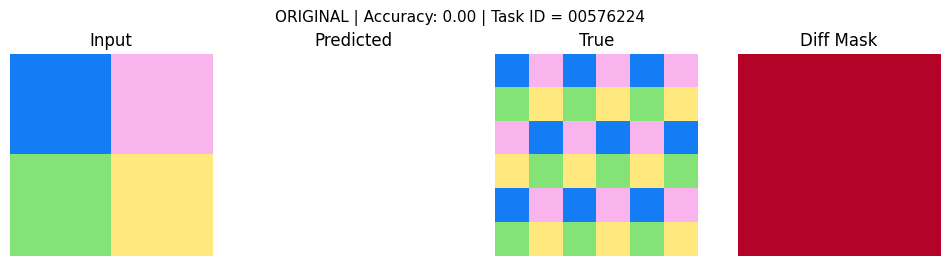


ResizeAgent - retileToShape | ✅ Accuracy: 0.667 | Task ID = 00576224


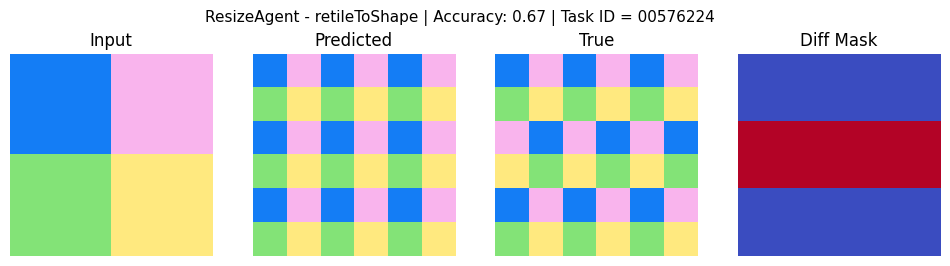


ResizeAgent - growToShape | ✅ Accuracy: 0.333 | Task ID = 00576224


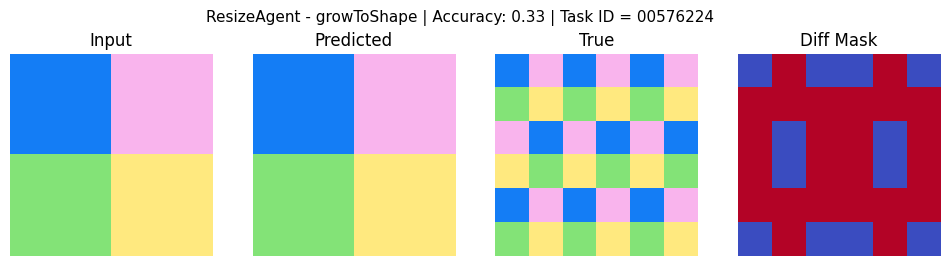


ResizeAgent - retileAndGrow | ✅ Accuracy: 0.667 | Task ID = 00576224


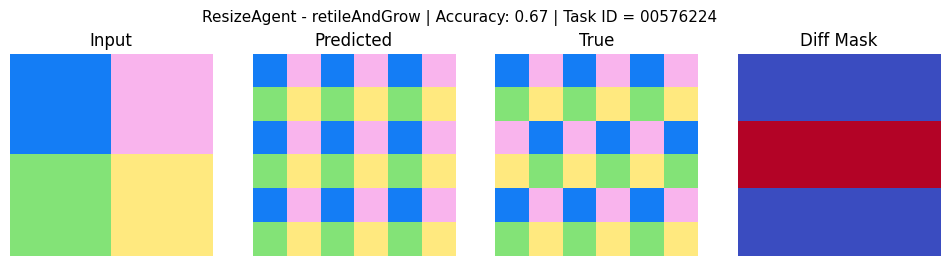


TransformsAgent - horizontalFlip | ✅ Accuracy: 1.000 | Task ID = 00576224


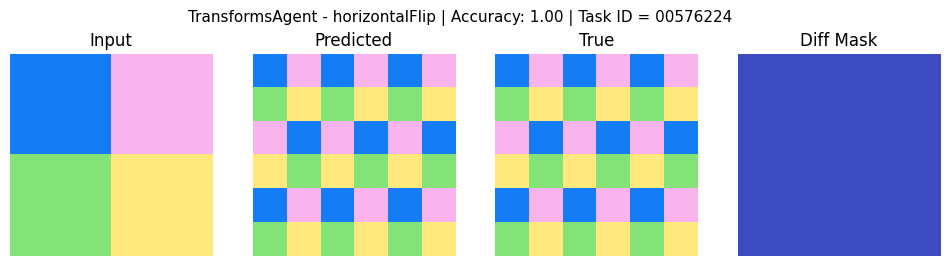


ORIGINAL | ✅ Accuracy: 0.000 | Task ID = 00576224


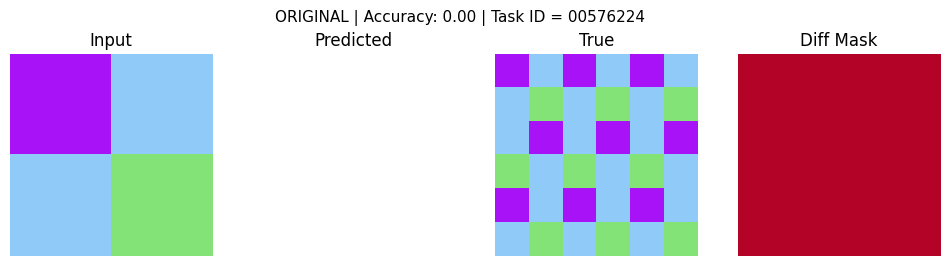


ResizeAgent - retileToShape | ✅ Accuracy: 0.667 | Task ID = 00576224


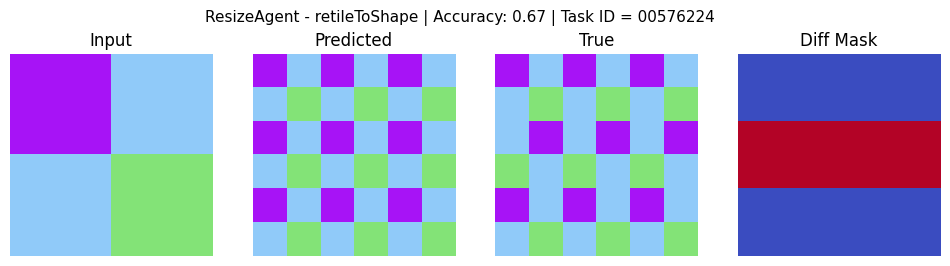


ResizeAgent - growToShape | ✅ Accuracy: 0.389 | Task ID = 00576224


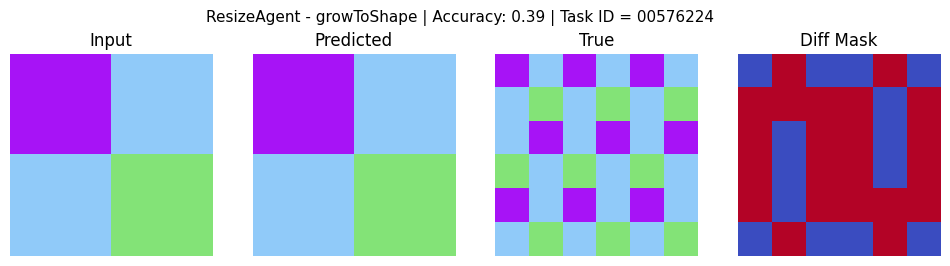


ResizeAgent - retileAndGrow | ✅ Accuracy: 0.667 | Task ID = 00576224


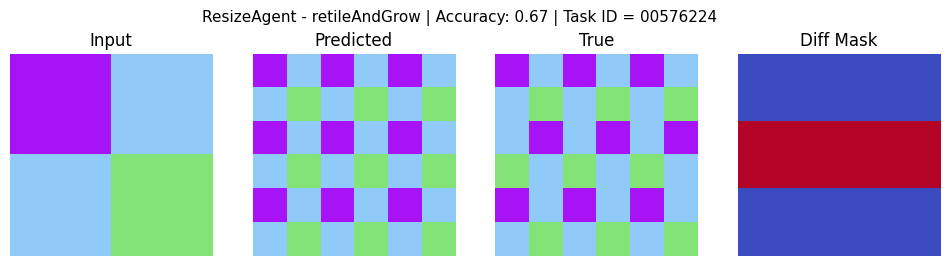


TransformsAgent - horizontalFlip | ✅ Accuracy: 1.000 | Task ID = 00576224


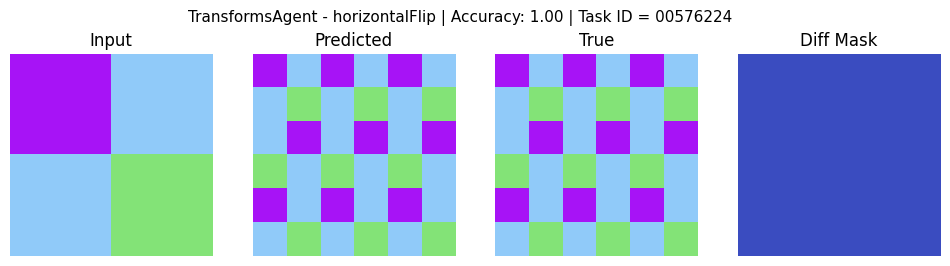




========== SOLVING TEST PROBLEM ==========





ORIGINAL | ✅ Accuracy: 0.691 | Task ID = 007bbfb7


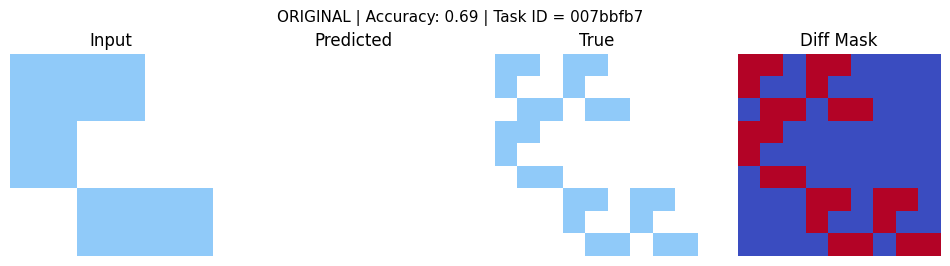


ResizeAgent - retileToShape | ✅ Accuracy: 0.753 | Task ID = 007bbfb7


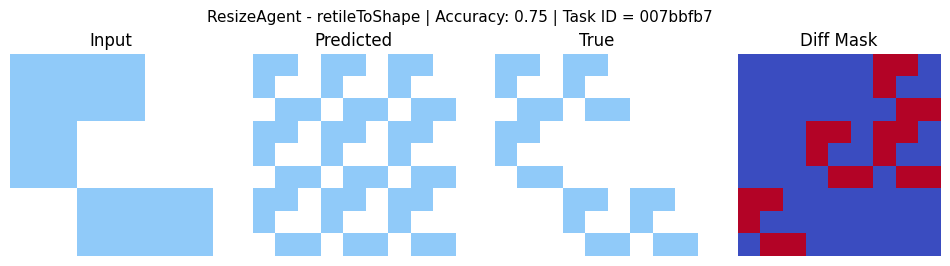


ResizeAgent - growToShape | ✅ Accuracy: 0.753 | Task ID = 007bbfb7


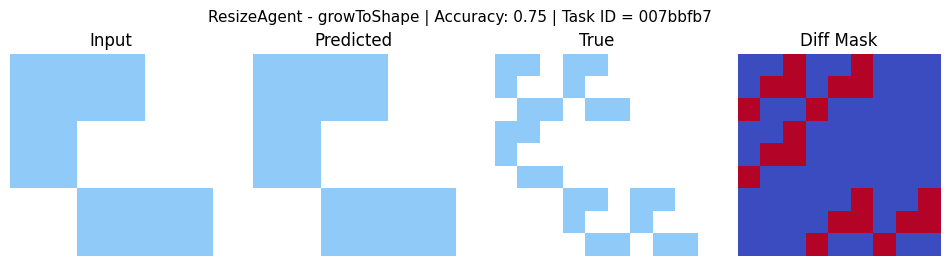


ResizeAgent - retileAndGrow | ✅ Accuracy: 1.000 | Task ID = 007bbfb7


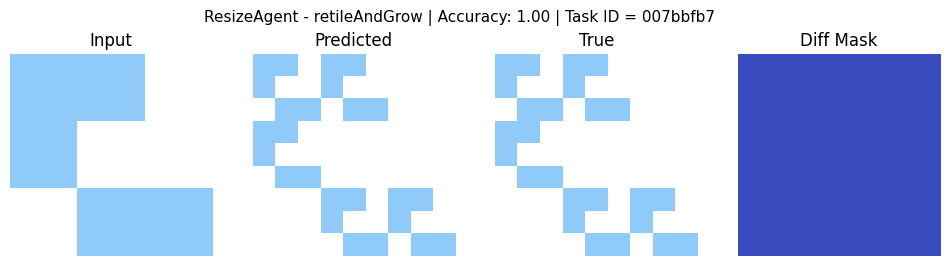


ORIGINAL | ✅ Accuracy: 0.889 | Task ID = 007bbfb7


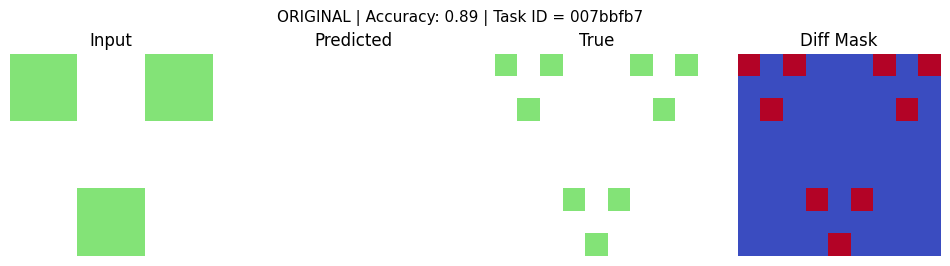


ResizeAgent - retileToShape | ✅ Accuracy: 0.778 | Task ID = 007bbfb7


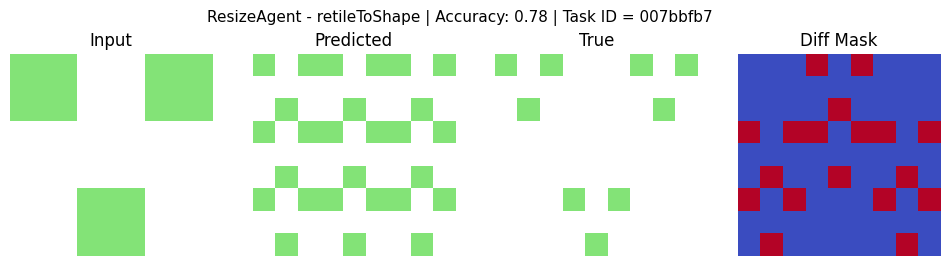


ResizeAgent - growToShape | ✅ Accuracy: 0.778 | Task ID = 007bbfb7


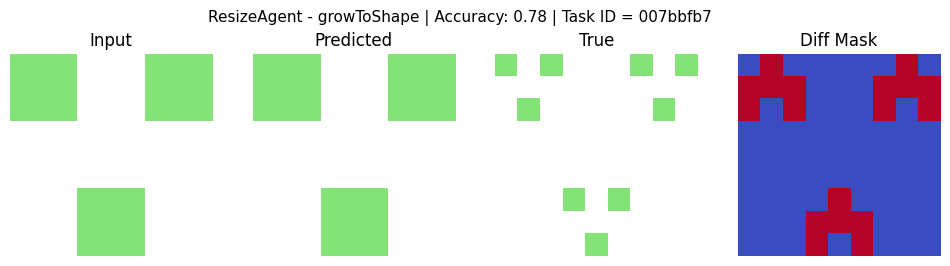


ResizeAgent - retileAndGrow | ✅ Accuracy: 1.000 | Task ID = 007bbfb7


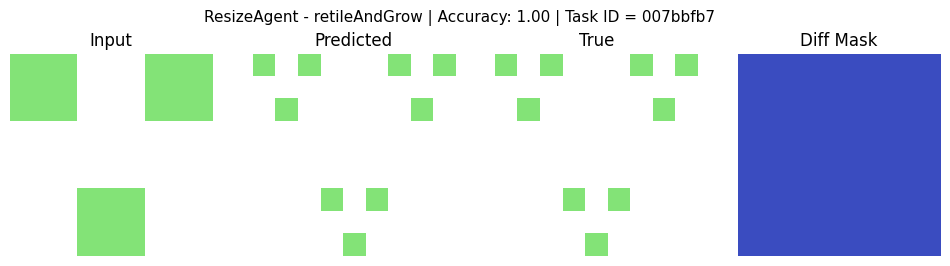


ORIGINAL | ✅ Accuracy: 0.889 | Task ID = 007bbfb7


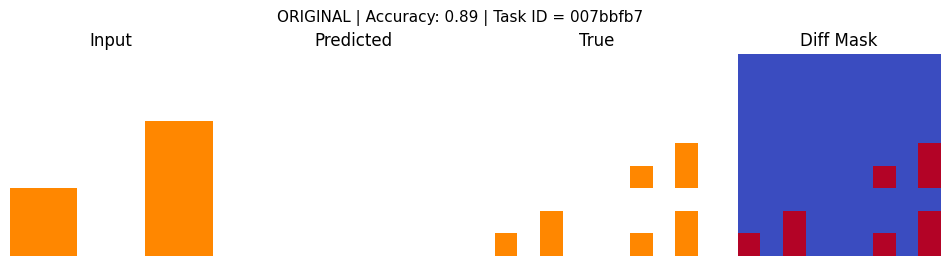


ResizeAgent - retileToShape | ✅ Accuracy: 0.778 | Task ID = 007bbfb7


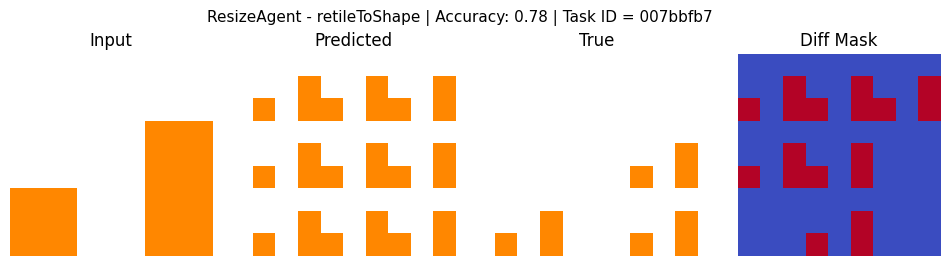


ResizeAgent - growToShape | ✅ Accuracy: 0.778 | Task ID = 007bbfb7


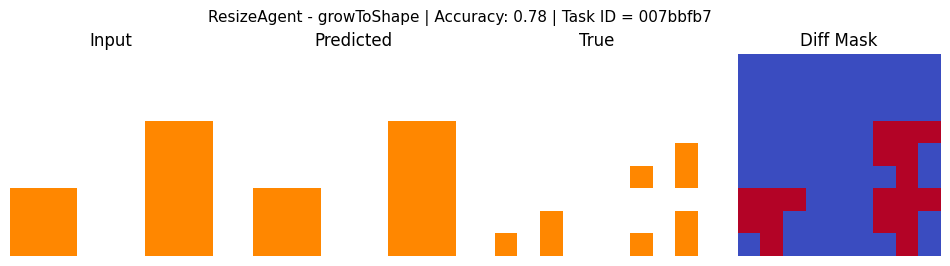


ResizeAgent - retileAndGrow | ✅ Accuracy: 1.000 | Task ID = 007bbfb7


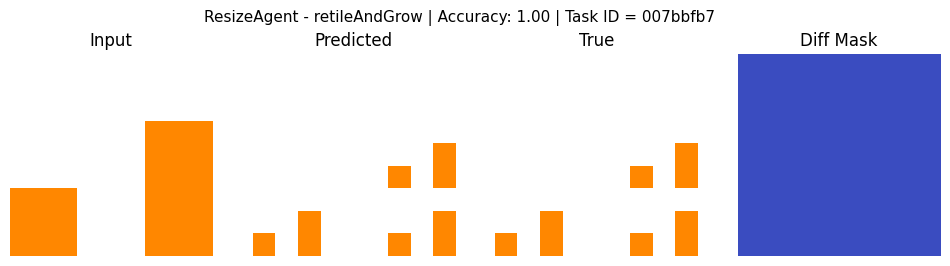


ORIGINAL | ✅ Accuracy: 0.691 | Task ID = 007bbfb7


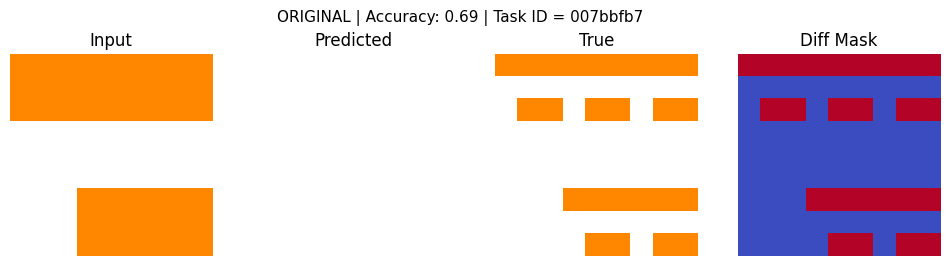


ResizeAgent - retileToShape | ✅ Accuracy: 0.753 | Task ID = 007bbfb7


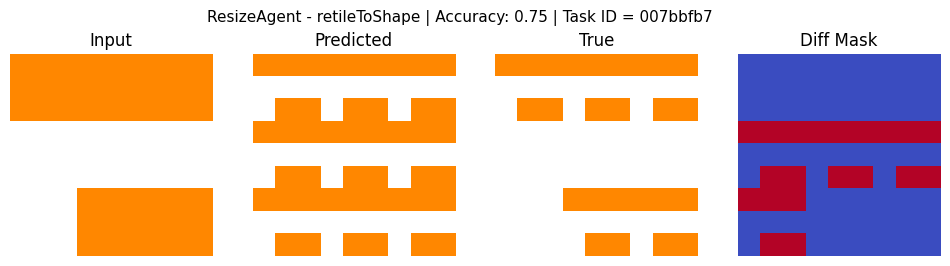


ResizeAgent - growToShape | ✅ Accuracy: 0.753 | Task ID = 007bbfb7


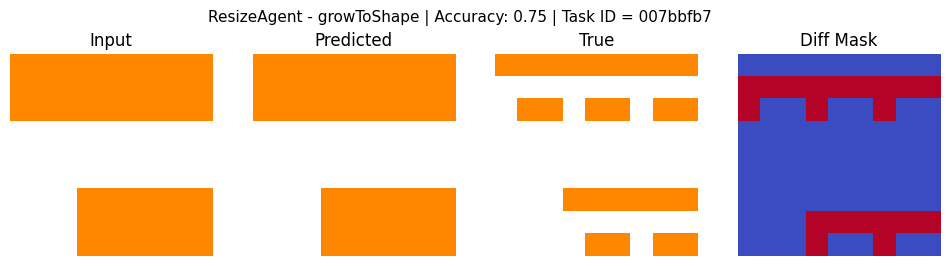


ResizeAgent - retileAndGrow | ✅ Accuracy: 1.000 | Task ID = 007bbfb7


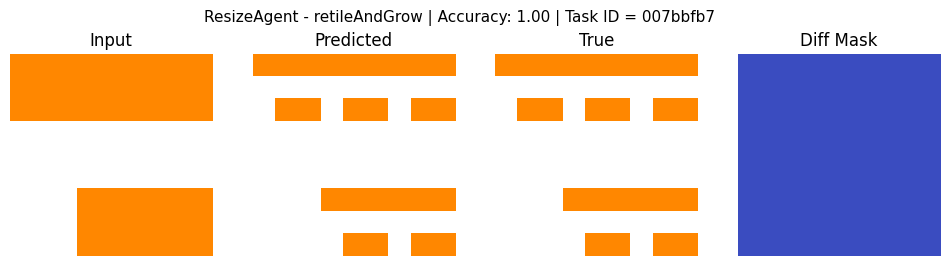


ORIGINAL | ✅ Accuracy: 0.395 | Task ID = 007bbfb7


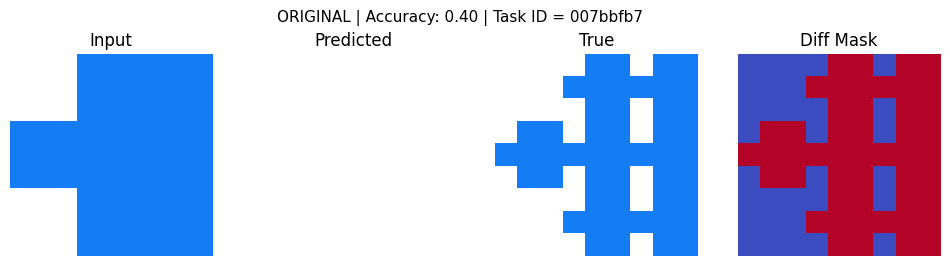


ResizeAgent - retileToShape | ✅ Accuracy: 0.827 | Task ID = 007bbfb7


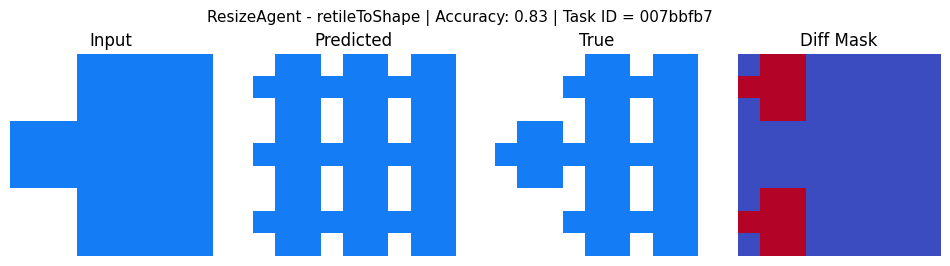


ResizeAgent - growToShape | ✅ Accuracy: 0.827 | Task ID = 007bbfb7


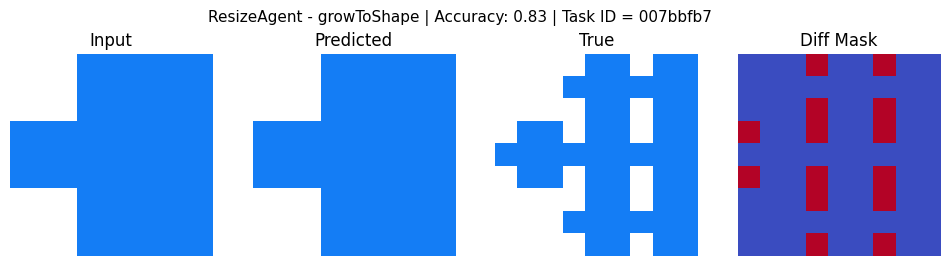


ResizeAgent - retileAndGrow | ✅ Accuracy: 1.000 | Task ID = 007bbfb7


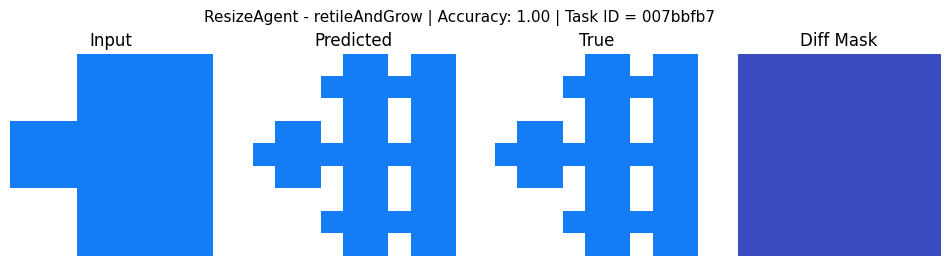




========== SOLVING TEST PROBLEM ==========
☑️ test problem solved





ORIGINAL | ✅ Accuracy: 0.811 | Task ID = 009d5c81


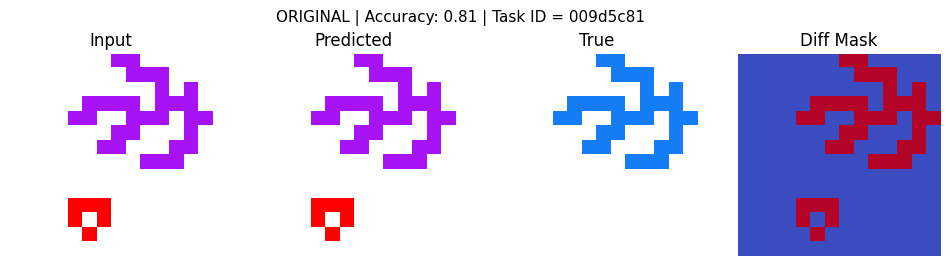


No resizing, using input | ✅ Accuracy: 0.811 | Task ID = 009d5c81


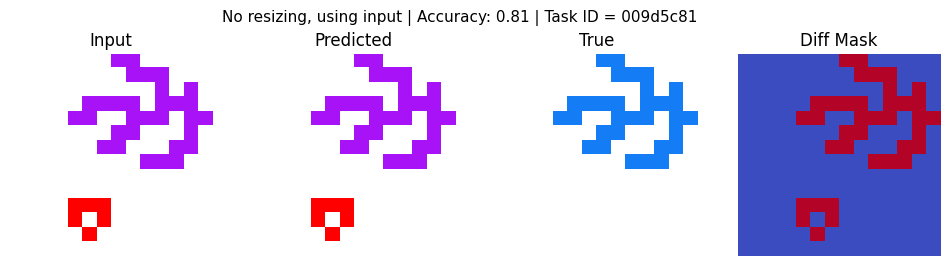


TransformsAgent - horizontalFlip | ✅ Accuracy: 0.842 | Task ID = 009d5c81


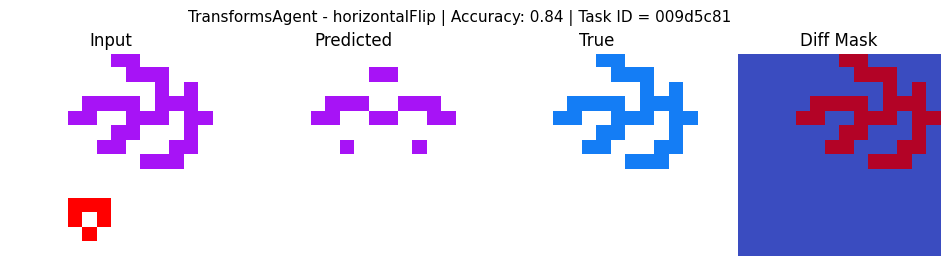


TransformsAgent - verticalFlip | ✅ Accuracy: 0.811 | Task ID = 009d5c81


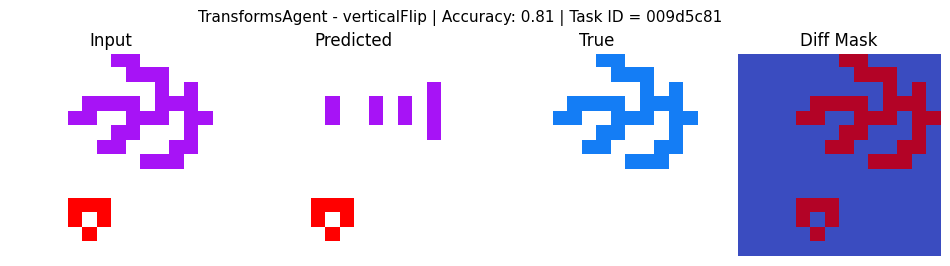


TransformsAgent - rotate90 | ✅ Accuracy: 0.842 | Task ID = 009d5c81


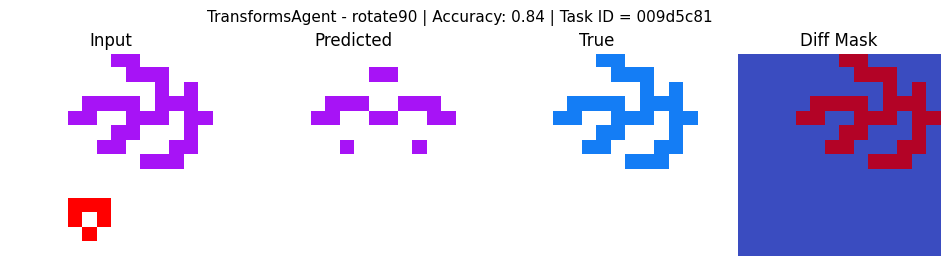


TransformsAgent - rotate180 | ✅ Accuracy: 0.811 | Task ID = 009d5c81


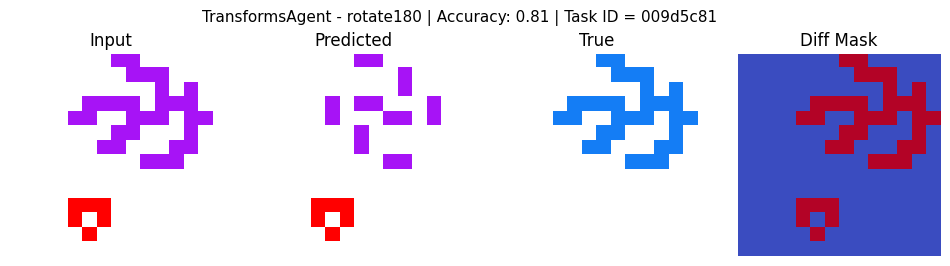


TransformsAgent - rotate270 | ✅ Accuracy: 0.842 | Task ID = 009d5c81


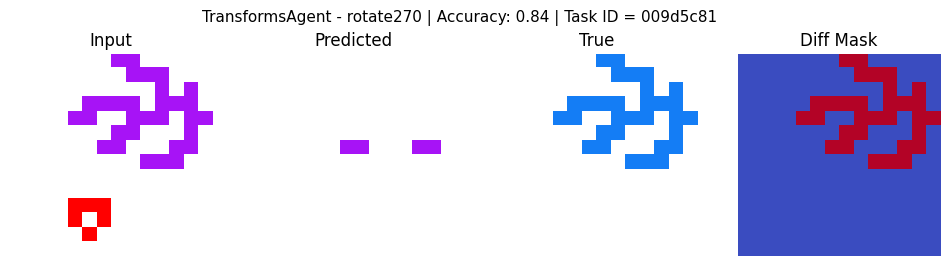


TransformsAgent - shiftUp | ✅ Accuracy: 0.811 | Task ID = 009d5c81


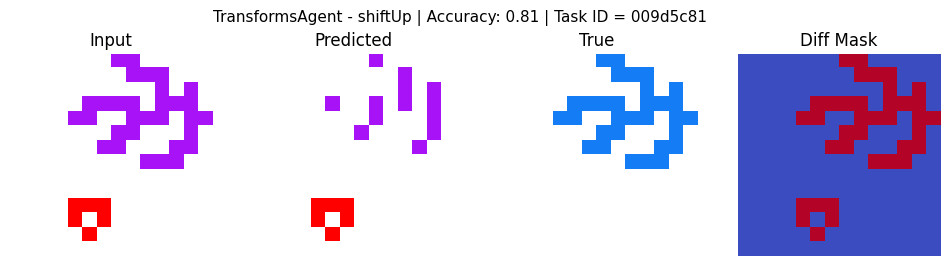


TransformsAgent - shiftDown | ✅ Accuracy: 0.832 | Task ID = 009d5c81


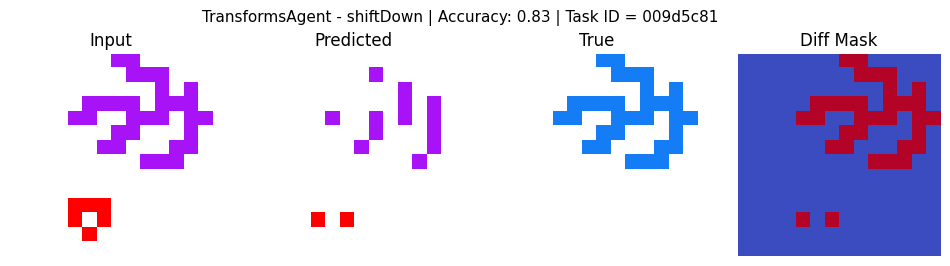


TransformsAgent - shiftLeft | ✅ Accuracy: 0.821 | Task ID = 009d5c81


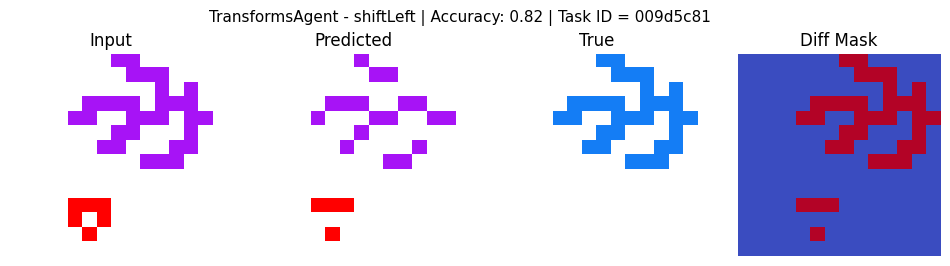


TransformsAgent - shiftRight | ✅ Accuracy: 0.821 | Task ID = 009d5c81


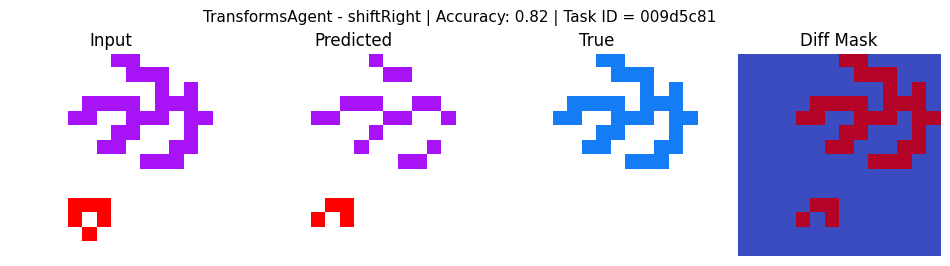


TransformsAgent - transpose | ✅ Accuracy: 0.811 | Task ID = 009d5c81


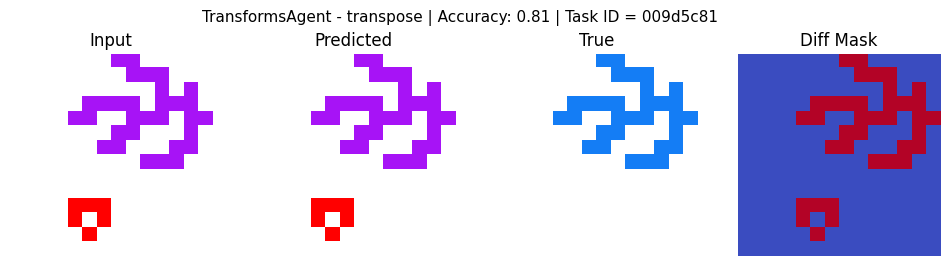


RecolorAgent - recolorMostCommonColor, color(s) = [7] | ✅ Accuracy: 0.969 | Task ID = 009d5c81


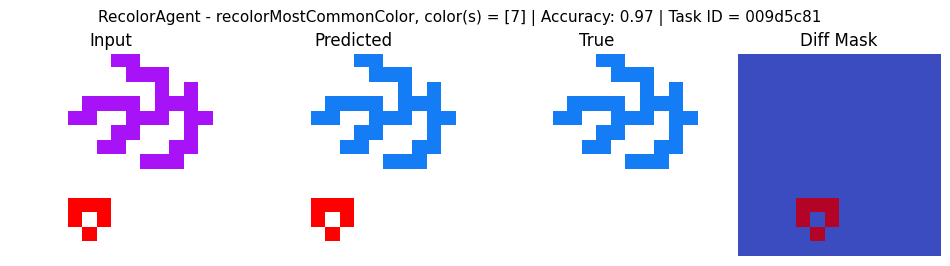


EraseAgent - eraseLeastCommonColor | ✅ Accuracy: 1.000 | Task ID = 009d5c81


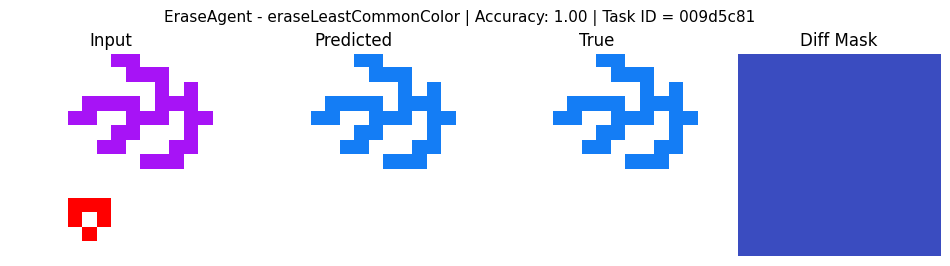


ORIGINAL | ✅ Accuracy: 0.898 | Task ID = 009d5c81


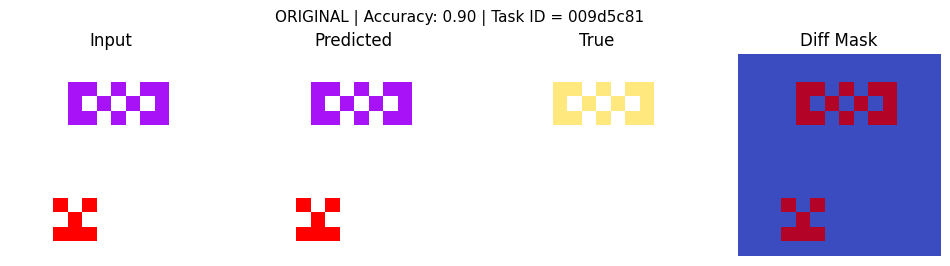


No resizing, using input | ✅ Accuracy: 0.898 | Task ID = 009d5c81


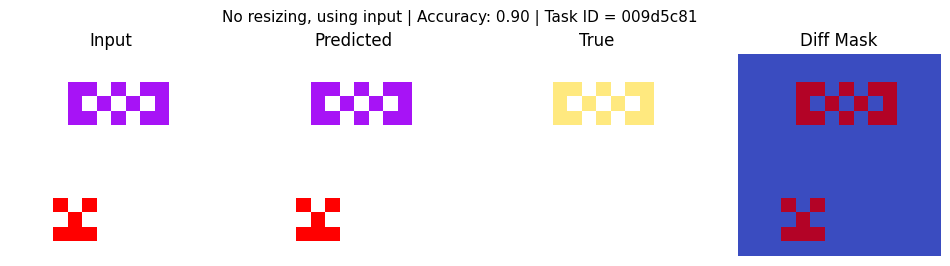


TransformsAgent - horizontalFlip | ✅ Accuracy: 0.929 | Task ID = 009d5c81


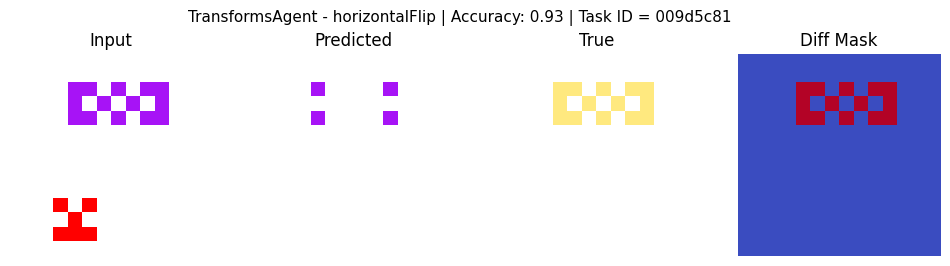


TransformsAgent - verticalFlip | ✅ Accuracy: 0.898 | Task ID = 009d5c81


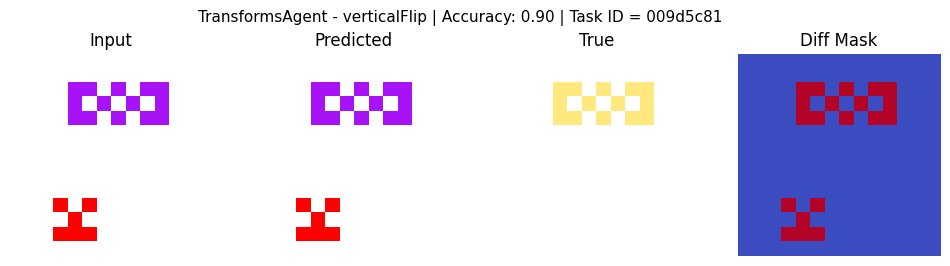


TransformsAgent - rotate90 | ✅ Accuracy: 0.929 | Task ID = 009d5c81


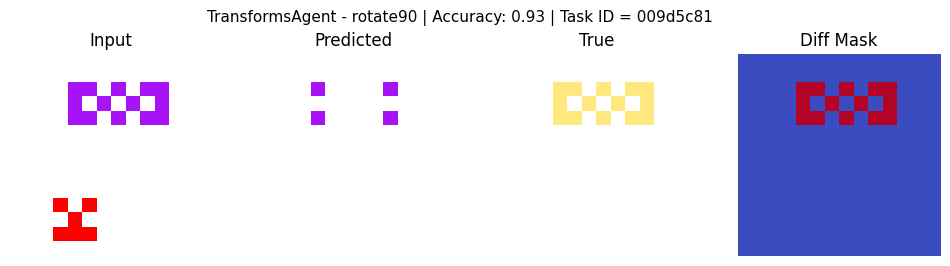


TransformsAgent - rotate180 | ✅ Accuracy: 0.898 | Task ID = 009d5c81


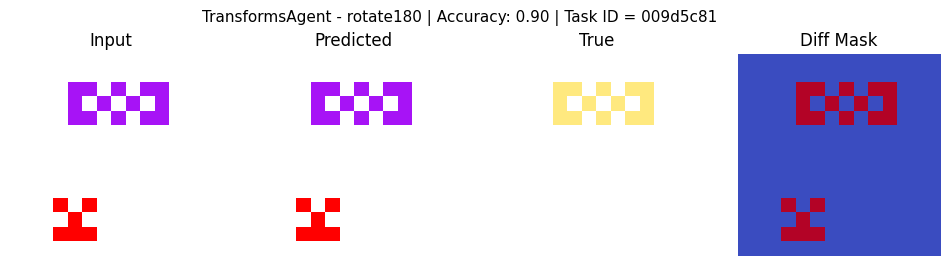


TransformsAgent - rotate270 | ✅ Accuracy: 0.908 | Task ID = 009d5c81


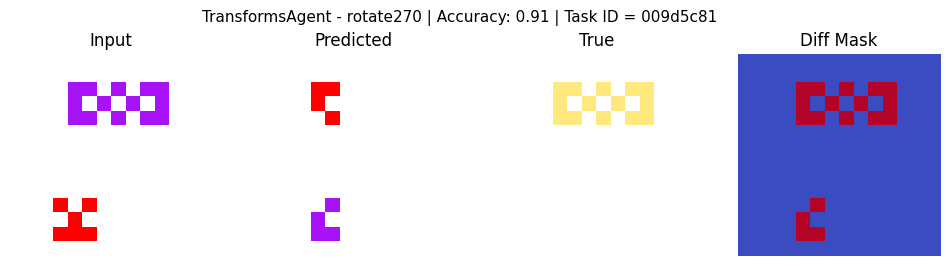


TransformsAgent - shiftUp | ✅ Accuracy: 0.903 | Task ID = 009d5c81


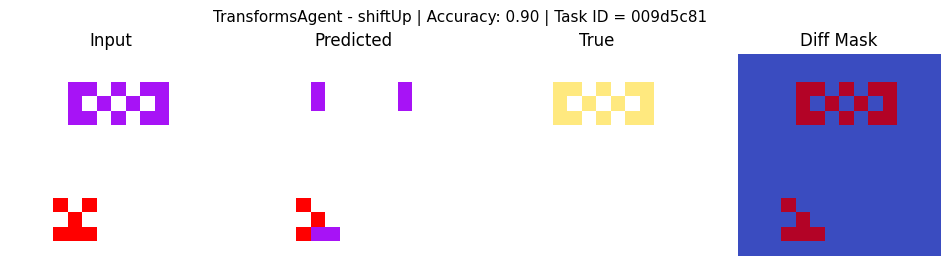


TransformsAgent - shiftDown | ✅ Accuracy: 0.918 | Task ID = 009d5c81


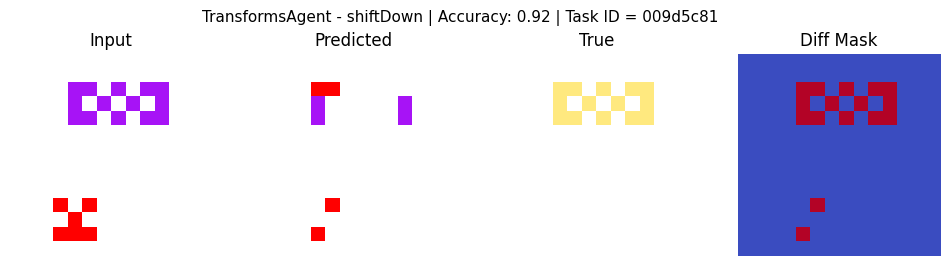


TransformsAgent - shiftLeft | ✅ Accuracy: 0.903 | Task ID = 009d5c81


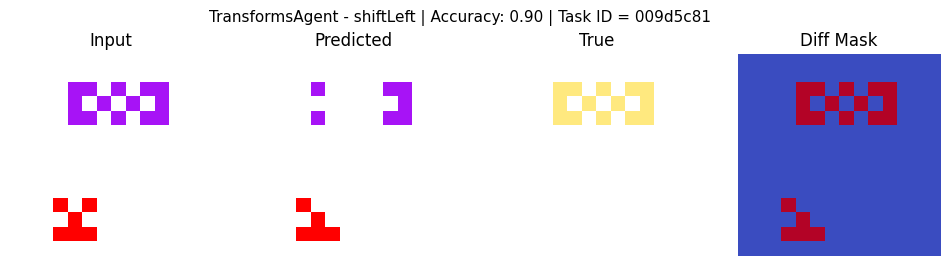


TransformsAgent - shiftRight | ✅ Accuracy: 0.913 | Task ID = 009d5c81


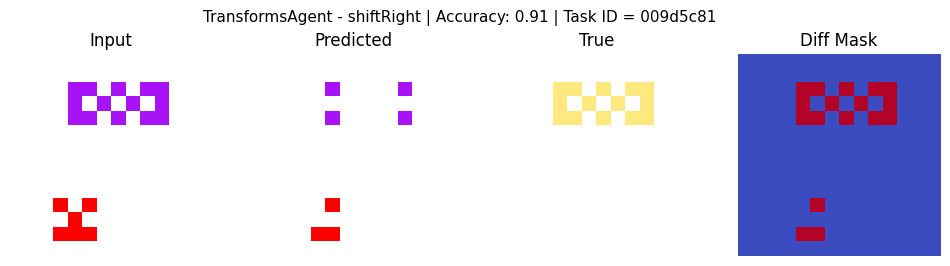


TransformsAgent - transpose | ✅ Accuracy: 0.898 | Task ID = 009d5c81


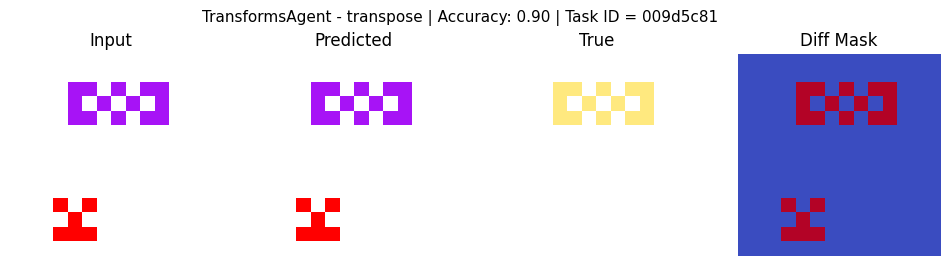


RecolorAgent - recolorMostCommonColor, color(s) = [7, 3] | ✅ Accuracy: 0.969 | Task ID = 009d5c81


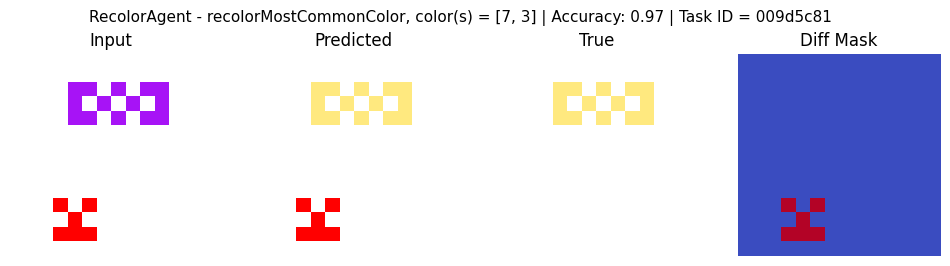


EraseAgent - eraseLeastCommonColor | ✅ Accuracy: 1.000 | Task ID = 009d5c81


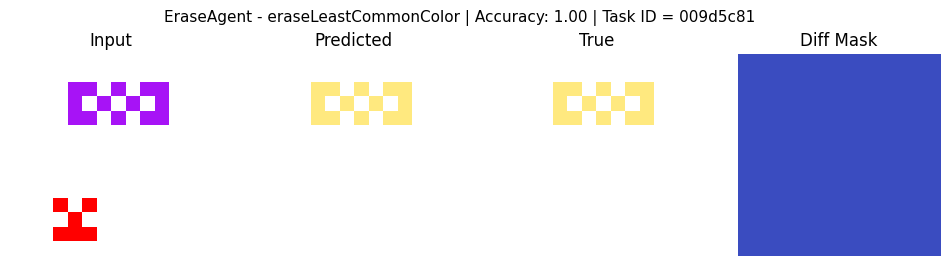


ORIGINAL | ✅ Accuracy: 0.852 | Task ID = 009d5c81


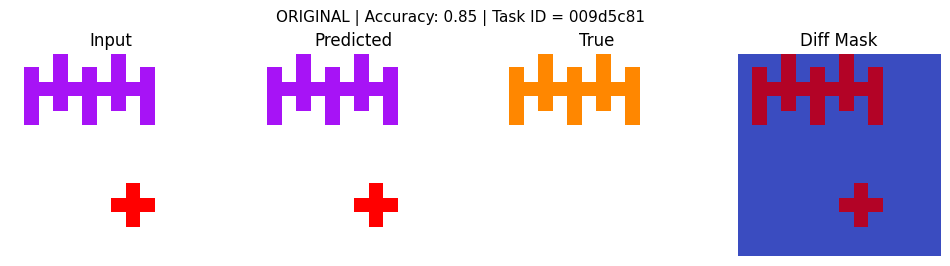


No resizing, using input | ✅ Accuracy: 0.852 | Task ID = 009d5c81


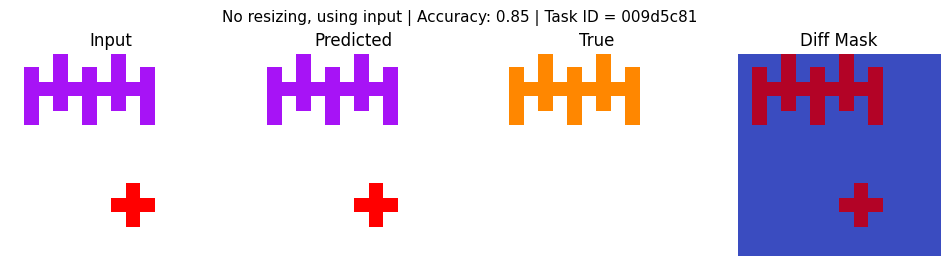


TransformsAgent - horizontalFlip | ✅ Accuracy: 0.878 | Task ID = 009d5c81


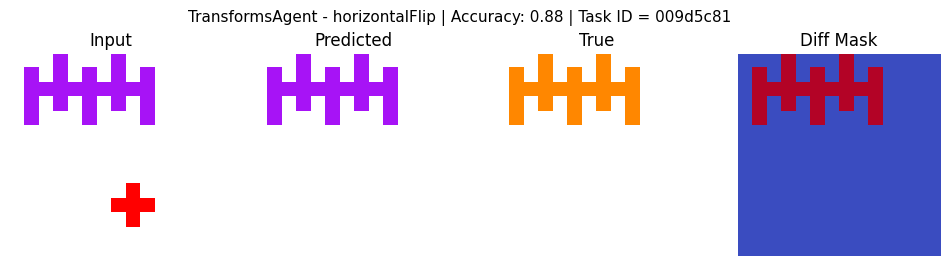


TransformsAgent - verticalFlip | ✅ Accuracy: 0.852 | Task ID = 009d5c81


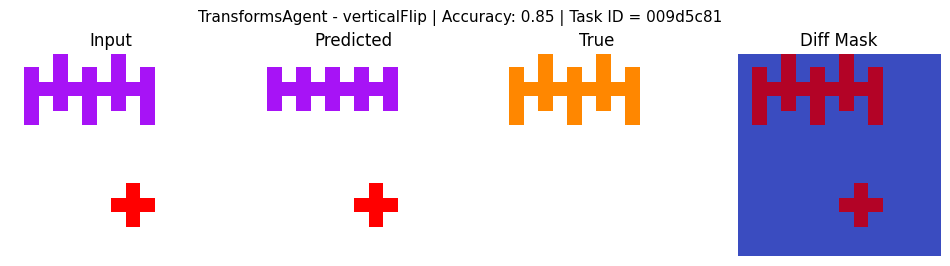


TransformsAgent - rotate90 | ✅ Accuracy: 0.878 | Task ID = 009d5c81


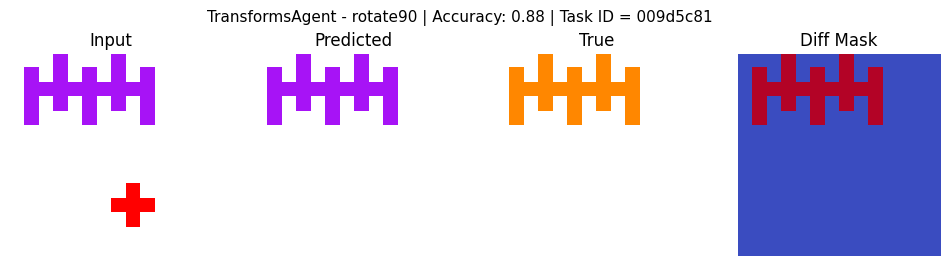


TransformsAgent - rotate180 | ✅ Accuracy: 0.852 | Task ID = 009d5c81


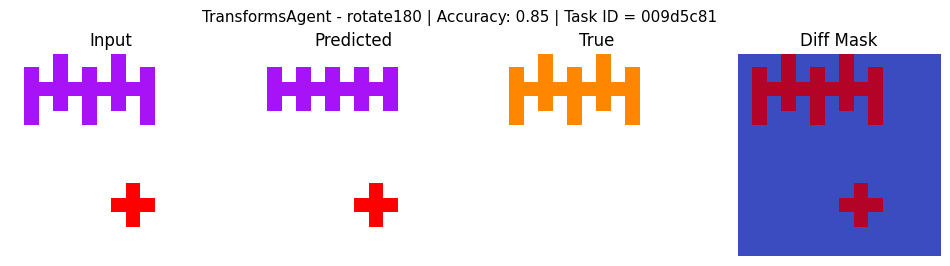


TransformsAgent - rotate270 | ✅ Accuracy: 0.862 | Task ID = 009d5c81


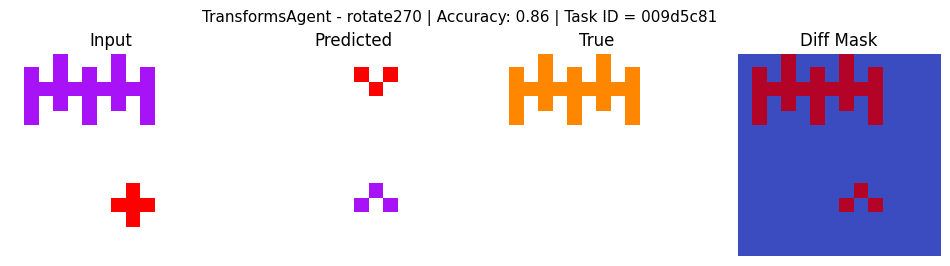


TransformsAgent - shiftUp | ✅ Accuracy: 0.857 | Task ID = 009d5c81


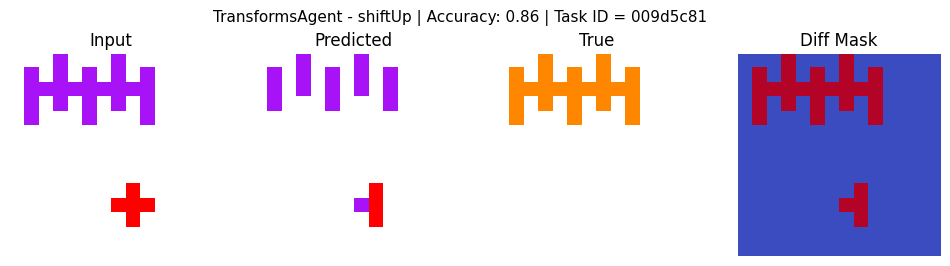


TransformsAgent - shiftDown | ✅ Accuracy: 0.862 | Task ID = 009d5c81


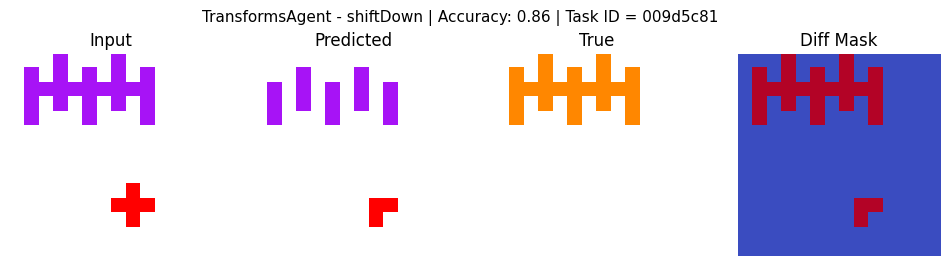


TransformsAgent - shiftLeft | ✅ Accuracy: 0.862 | Task ID = 009d5c81


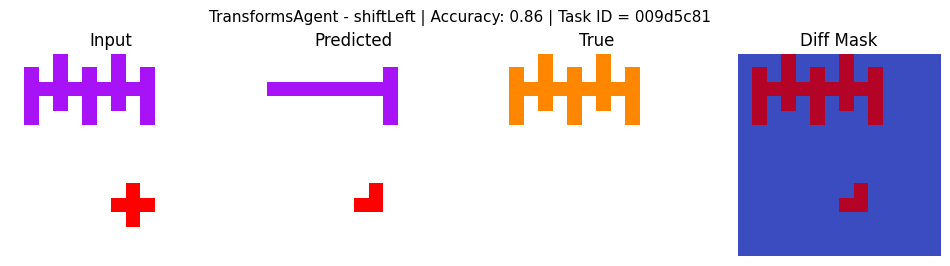


TransformsAgent - shiftRight | ✅ Accuracy: 0.862 | Task ID = 009d5c81


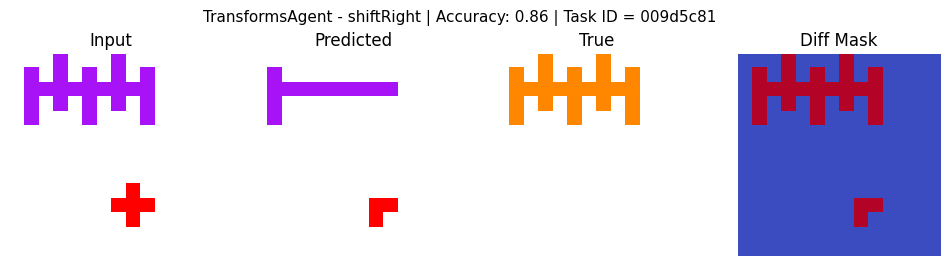


TransformsAgent - transpose | ✅ Accuracy: 0.852 | Task ID = 009d5c81


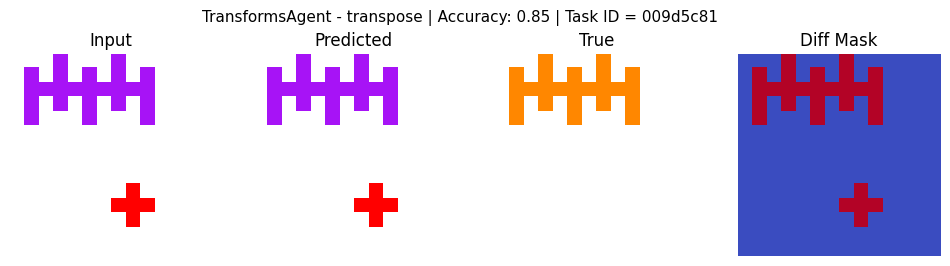


RecolorAgent - recolorMostCommonColor, color(s) = [7, 3, 2] | ✅ Accuracy: 0.974 | Task ID = 009d5c81


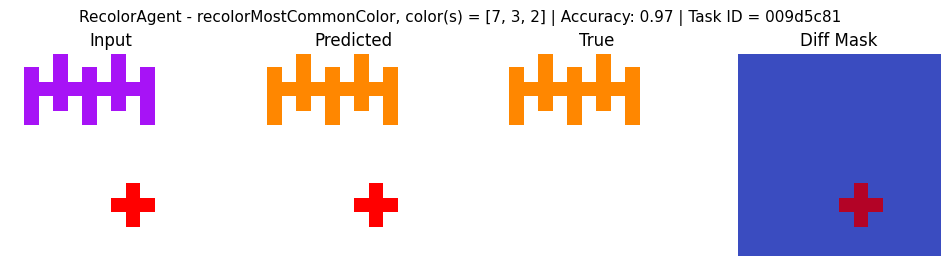


EraseAgent - eraseLeastCommonColor | ✅ Accuracy: 1.000 | Task ID = 009d5c81


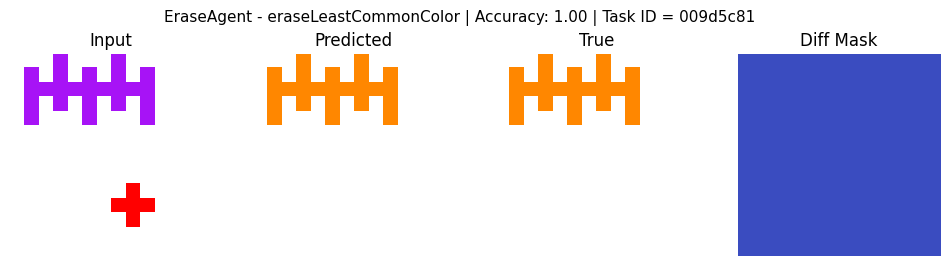


ORIGINAL | ✅ Accuracy: 0.888 | Task ID = 009d5c81


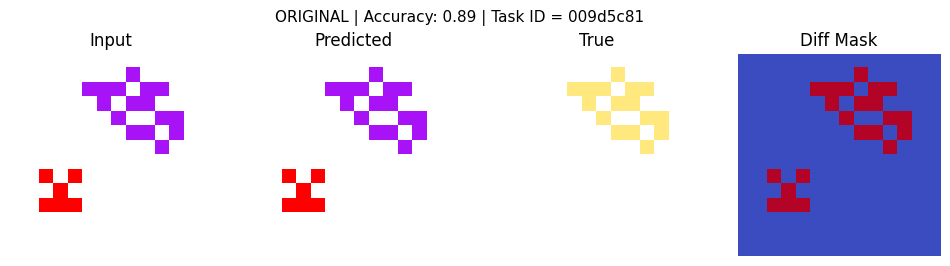


No resizing, using input | ✅ Accuracy: 0.888 | Task ID = 009d5c81


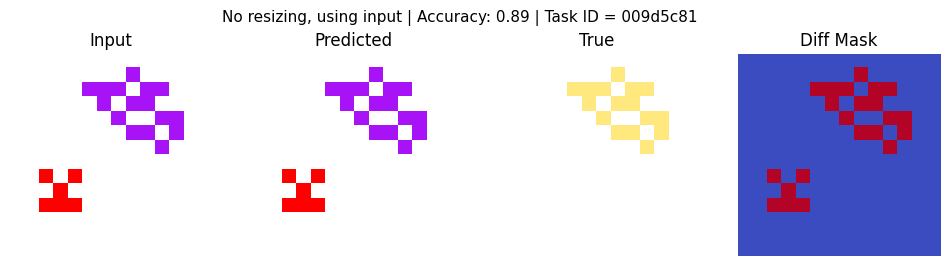


TransformsAgent - horizontalFlip | ✅ Accuracy: 0.918 | Task ID = 009d5c81


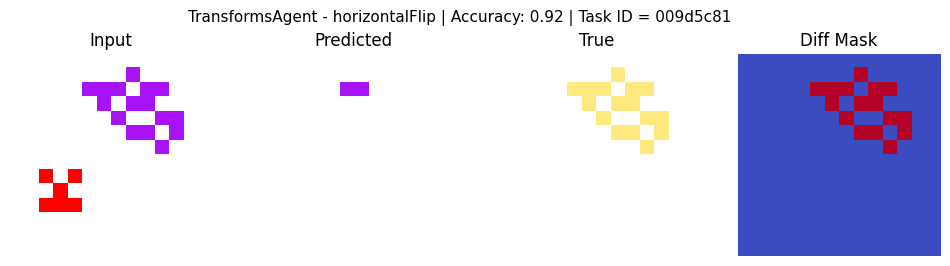


TransformsAgent - verticalFlip | ✅ Accuracy: 0.888 | Task ID = 009d5c81


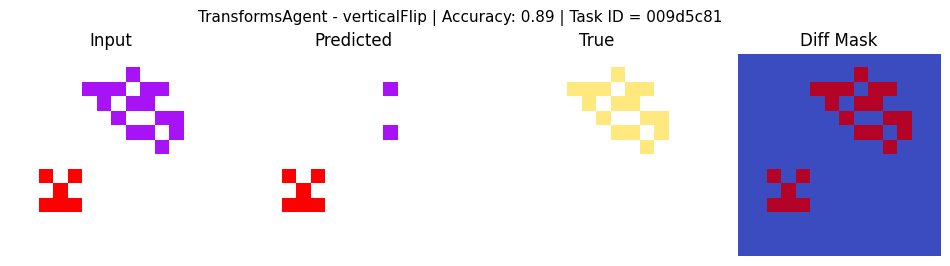


TransformsAgent - rotate90 | ✅ Accuracy: 0.918 | Task ID = 009d5c81


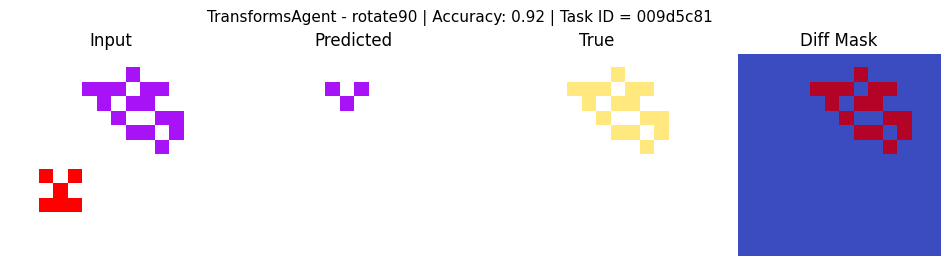


TransformsAgent - rotate180 | ✅ Accuracy: 0.888 | Task ID = 009d5c81


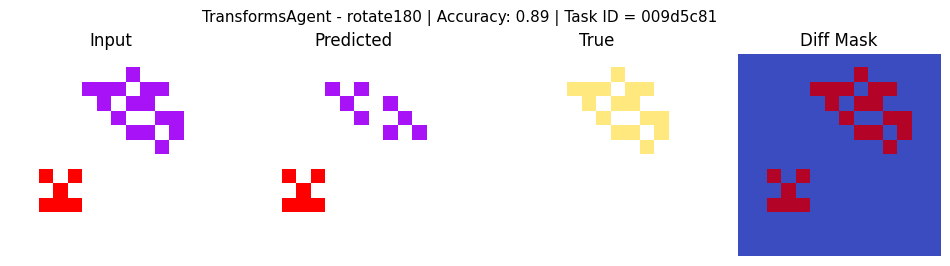


TransformsAgent - rotate270 | ✅ Accuracy: 0.918 | Task ID = 009d5c81


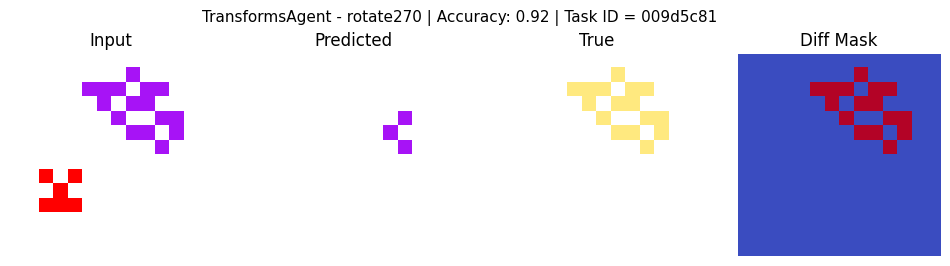


TransformsAgent - shiftUp | ✅ Accuracy: 0.888 | Task ID = 009d5c81


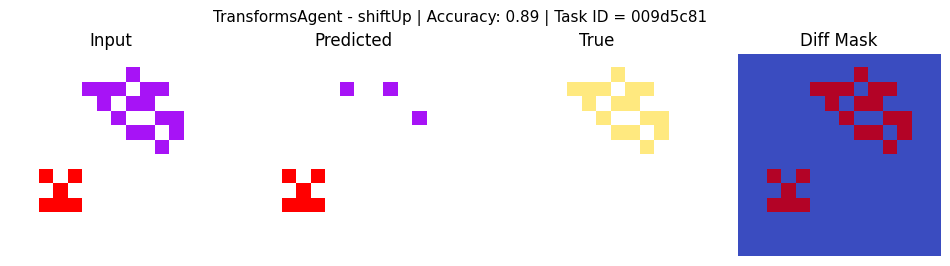


TransformsAgent - shiftDown | ✅ Accuracy: 0.913 | Task ID = 009d5c81


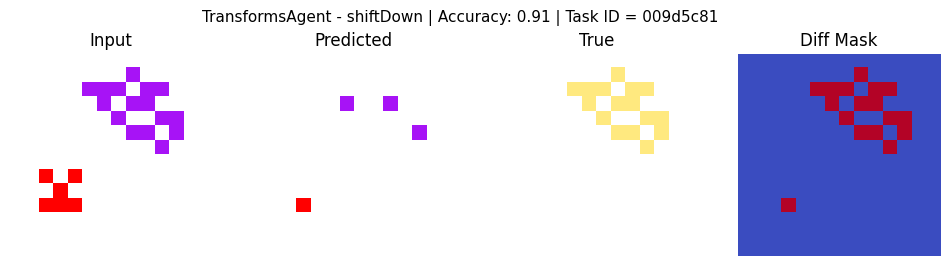


TransformsAgent - shiftLeft | ✅ Accuracy: 0.888 | Task ID = 009d5c81


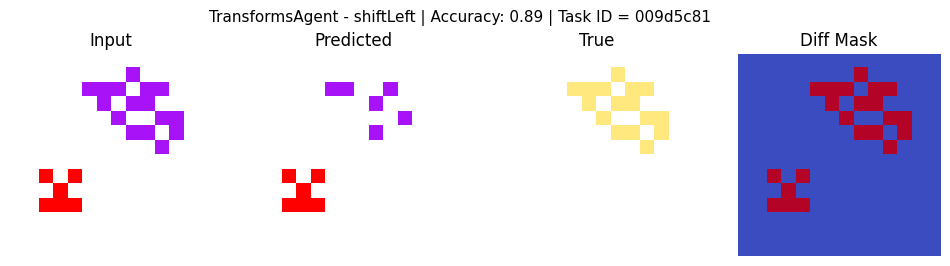


TransformsAgent - shiftRight | ✅ Accuracy: 0.908 | Task ID = 009d5c81


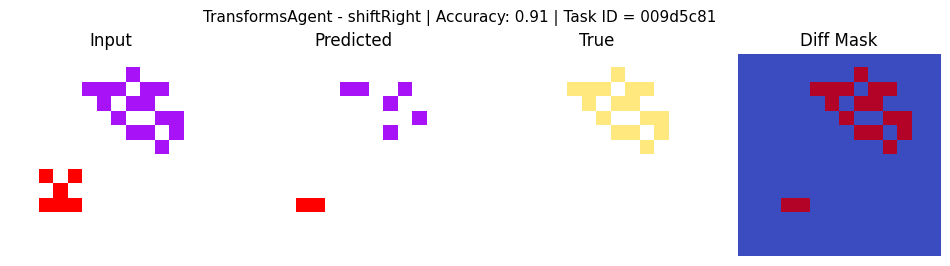


TransformsAgent - transpose | ✅ Accuracy: 0.888 | Task ID = 009d5c81


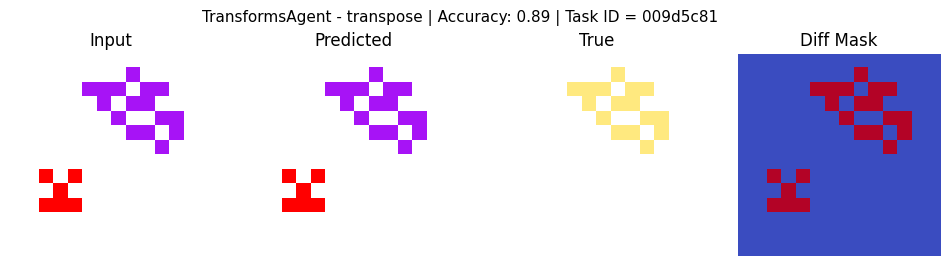


RecolorAgent - recolorMostCommonColor, color(s) = [7, 3, 2, 3] | ✅ Accuracy: 0.969 | Task ID = 009d5c81


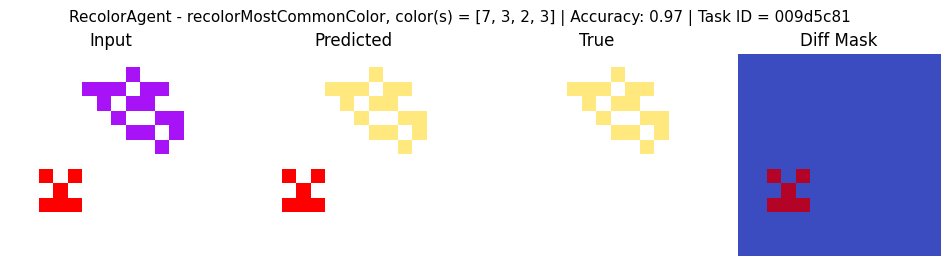


EraseAgent - eraseLeastCommonColor | ✅ Accuracy: 1.000 | Task ID = 009d5c81


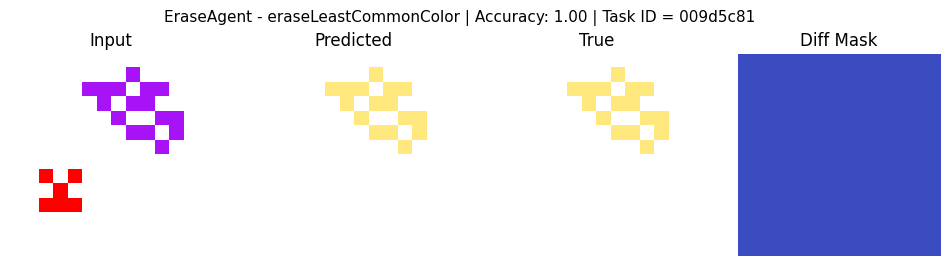


ORIGINAL | ✅ Accuracy: 0.821 | Task ID = 009d5c81


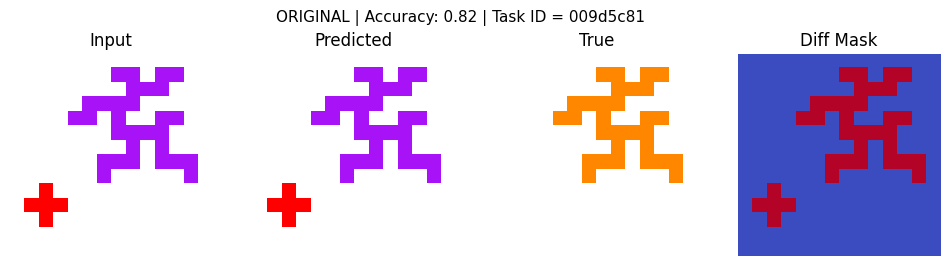


No resizing, using input | ✅ Accuracy: 0.821 | Task ID = 009d5c81


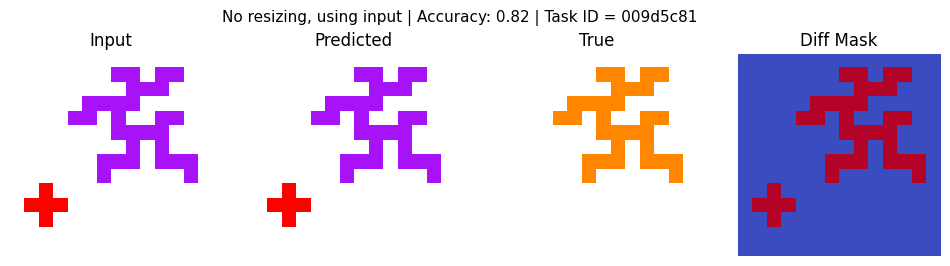


TransformsAgent - horizontalFlip | ✅ Accuracy: 0.847 | Task ID = 009d5c81


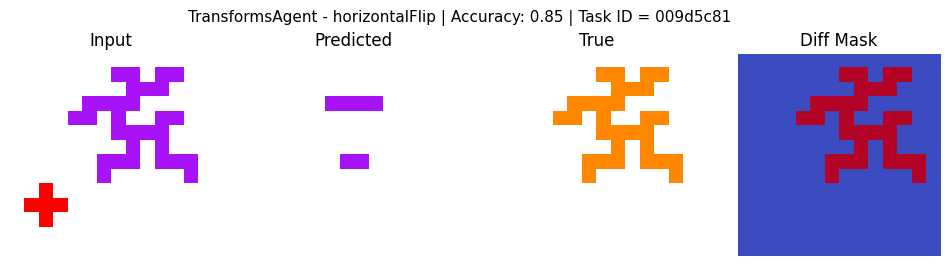


TransformsAgent - verticalFlip | ✅ Accuracy: 0.821 | Task ID = 009d5c81


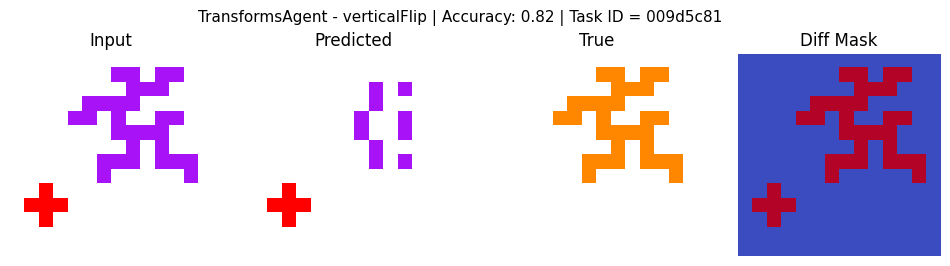


TransformsAgent - rotate90 | ✅ Accuracy: 0.847 | Task ID = 009d5c81


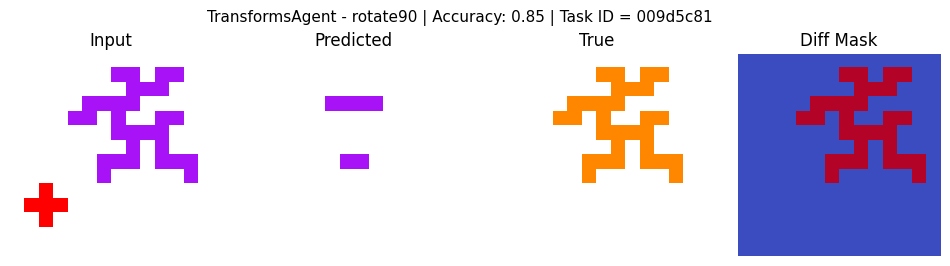


TransformsAgent - rotate180 | ✅ Accuracy: 0.821 | Task ID = 009d5c81


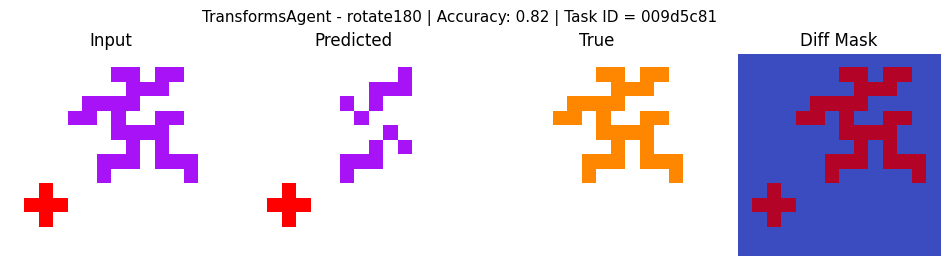


TransformsAgent - rotate270 | ✅ Accuracy: 0.847 | Task ID = 009d5c81


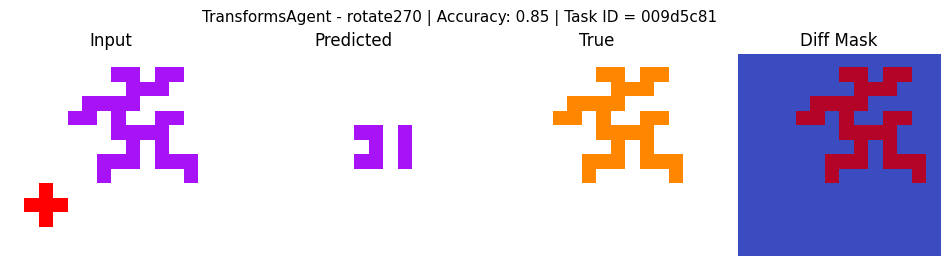


TransformsAgent - shiftUp | ✅ Accuracy: 0.821 | Task ID = 009d5c81


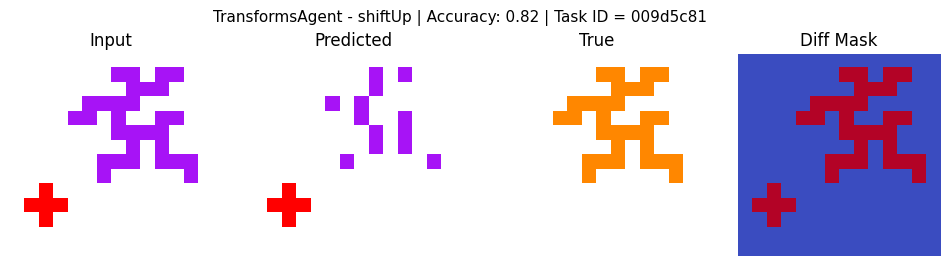


TransformsAgent - shiftDown | ✅ Accuracy: 0.837 | Task ID = 009d5c81


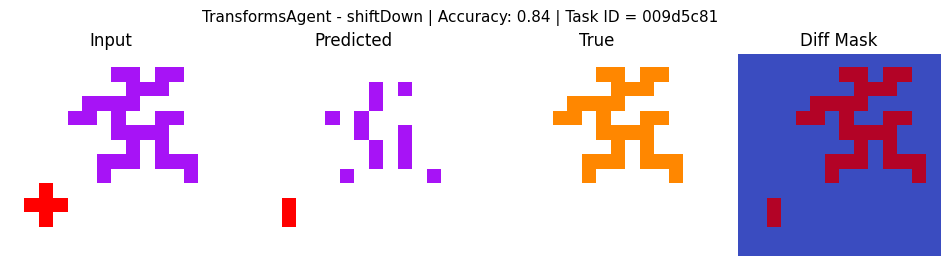


TransformsAgent - shiftLeft | ✅ Accuracy: 0.827 | Task ID = 009d5c81


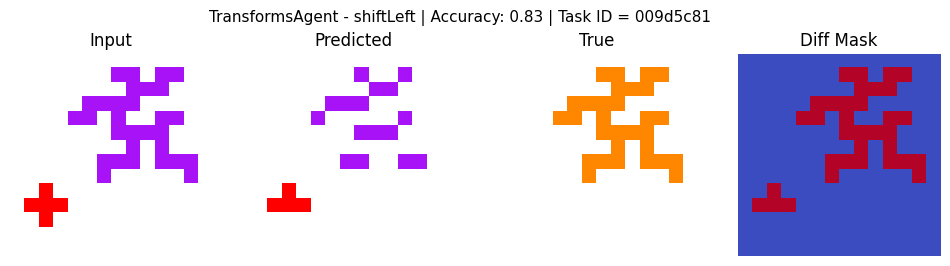


TransformsAgent - shiftRight | ✅ Accuracy: 0.832 | Task ID = 009d5c81


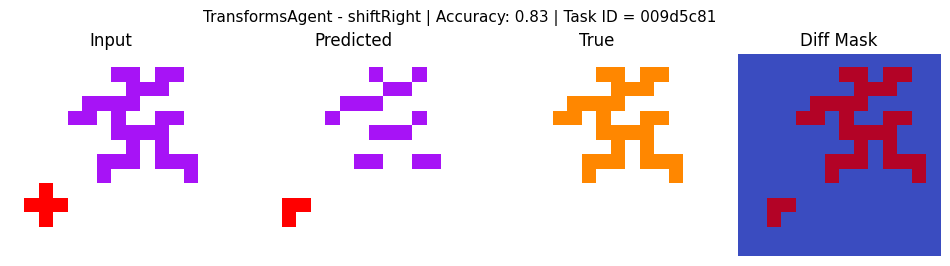


TransformsAgent - transpose | ✅ Accuracy: 0.832 | Task ID = 009d5c81


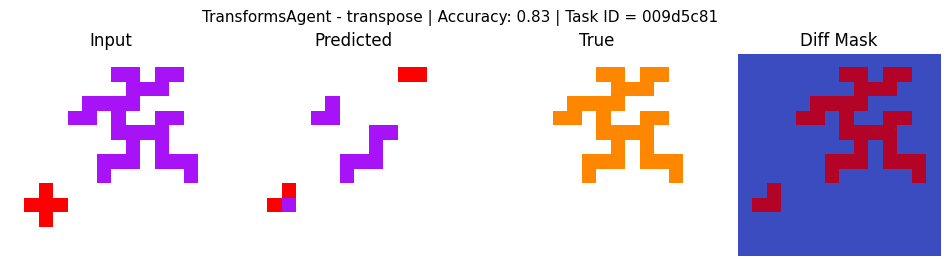


RecolorAgent - recolorMostCommonColor, color(s) = [7, 3, 2, 3, 2] | ✅ Accuracy: 0.974 | Task ID = 009d5c81


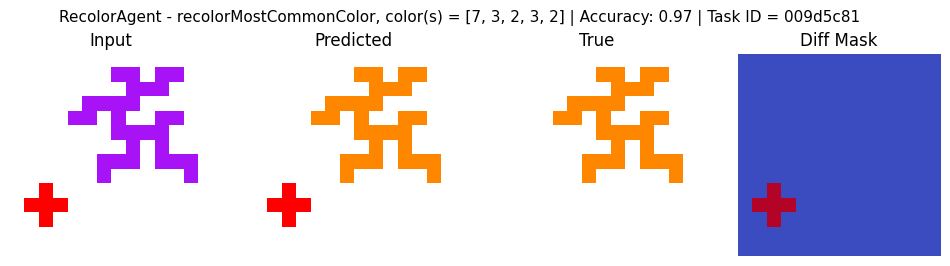


EraseAgent - eraseLeastCommonColor | ✅ Accuracy: 1.000 | Task ID = 009d5c81


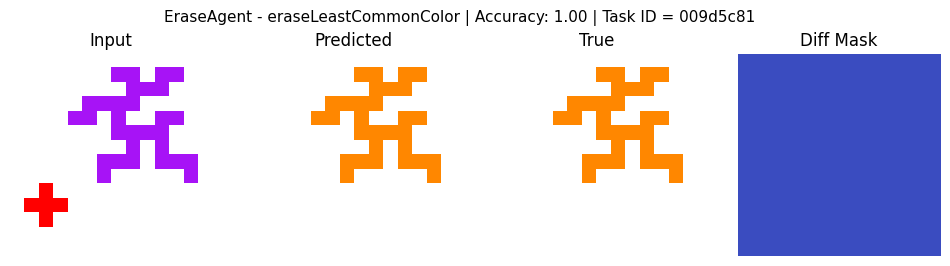




========== SOLVING TEST PROBLEM ==========


TypeError: RecolorAgent.operations.<locals>.<lambda>() missing 1 required positional argument: 'true_arr'

In [ ]:
# Attempt first few examples
start = 0
stop = 4
test_one = False
task_count = 0
all_accuracies = []
solved = 0

for id in train_ids[start:stop]:
# Fetch test from arc-agi_training_challenges.json
    input_test_arr, true_test_arr = train_data[id]["test"][0]["input"], train_label[id][0]
    input_test_arr, true_test_arr = convert_2D_numpy(input_test_arr), convert_2D_numpy(true_test_arr)
    predict_test_arr = np.copy(input_test_arr)
    best_accuracy = 0

# Define Agents
    resize_agent = ResizeAgent()
    transforms_agent = TransformsAgent()
    recolor_agent = RecolorAgent()
    erase_agent = EraseAgent()
    fill_gaps_agent = FillGapsAgent()
    # connected_components_agent = ConnectedComponentsAgent()

    agents = [
        {"agent": resize_agent, "name": "ResizeAgent"},
        {"agent": transforms_agent, "name": "TransformsAgent"},
        {"agent": recolor_agent, "name": "RecolorAgent"},
        {"agent": erase_agent, "name": "EraseAgent"},
        {"agent": fill_gaps_agent, "name": "FillGapsAgent"}
    ]

# Fetch train from arc-agi_training_challenges.json
    examples = train_data[id]["train"]
    all_learned_operations = []
    all_solved = True # Assume agents solves every example
    examples_summaries = []

    for example in examples:
        input_arr, true_arr = example["input"], example["output"]
        input_arr, true_arr = convert_2D_numpy(input_arr), convert_2D_numpy(true_arr)
        predict_arr = np.copy(input_arr)
        best_arr = np.copy(input_arr)
        accuracy, diff_mask = visualize_diff(input_arr, predict_arr, true_arr, id, "ORIGINAL")
        all_learned_operations.append([])  # Add empty array for operations
        if accuracy >= 1.0:
            continue

        for agent_info in agents:
            agent = agent_info["agent"]
            agent_name = agent_info["name"]
            predict_arr, new_accuracy = agent.try_all_operations(input_arr, predict_arr, true_arr, id, accuracy)
            if new_accuracy > accuracy:
                all_learned_operations[-1].append({agent_name: agent.learned_operations})
                best_arr = np.copy(predict_arr)
                accuracy = new_accuracy
            if accuracy >= 1.0:
                break
        # LLM help
        if accuracy < 1.0: # Not solved
            all_solved = False
            print("🧠 May need to use LLM for solving")
            example_summary = create_example_summary(accuracy, all_learned_operations[-1], best_arr, input_arr, true_arr)
            examples_summaries.append(example_summary)
    recommeneded_operations = []

# CALL ON LLM TO SOLVE!
    if not all_solved:
        final_prompt = create_final_prompt(examples_summaries)
        print(final_prompt)
        LLM_response = call_falcon_llm(final_prompt)
        recommeneded_operations = RAG_numpy_functions(LLM_response)

# Implement learned operations from training examples on test arr
    is_solved = False  # flag to stop all loops
    print("\n\n\n========== SOLVING TEST PROBLEM ==========")
    for ops_per_example in all_learned_operations:
        if is_solved:
            break
        for op_group in ops_per_example:
            if is_solved:
                break
            for agent_name, operations in op_group.items():
                if is_solved:
                    break
                for operation, description in operations:
                    predict_test_arr = operation(predict_test_arr)
                    test_accuracy = calculate_accuracy(predict_test_arr, true_test_arr)
                    if test_accuracy > best_accuracy:
                        best_accuracy = test_accuracy
                    if test_accuracy >= 1.0:
                        is_solved = True
                        break  # exit innermost loop

    # After loops
    if is_solved:
        print("☑️ test problem solved")
        solved += 1
    print("\n\n\n")
# Evaluation calculations
    task_count += 1
    all_accuracies.append(best_accuracy)

# Display Evaluation
fine_grained_accuracy = math.fsum(all_accuracies) / task_count # Accuracy / Total problems
task_level_accuracy = solved / task_count # Completely correct / Total problems
print("\n\n\nFINAL EVALUATION SCORES")
print(f"Fine-grained accuracy = {fine_grained_accuracy:.3f}")
print(f"Task-level accuracy = {task_level_accuracy:.3f}")